In [1]:
%cd ..

/home/seb/Perso/git/sudoku/sudoku_clean_v2


In [2]:
import torch
import pytorch_lightning as pl
from torch import nn
import torch.nn.functional as F
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sudoku.models import SmallNet, SymPreprocess
from sudoku.loader import DataIterBuffer, train_dataset, test_dataset, data_loader, get_datasets
from sudoku.helper import display_as_dataframe

from collections import deque
from typing import Tuple


from torchmetrics import AUROC
from torch.utils.data.dataset import IterableDataset
from torch.utils.data import  DataLoader

from pytorch_lightning.callbacks import ModelCheckpoint
from lightning_lite.utilities.seed import seed_everything

import numpy as np


import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))


In [3]:
torch.cuda.is_available()
tensorboard = pl.loggers.TensorBoardLogger(save_dir="")

In [4]:
seed_everything(seed=1)

Global seed set to 1


1

In [5]:
train_dataset, test_dataset = get_datasets(train_size=1280, test_size=1280)

In [6]:
test_x, test_y = tuple(next(iter(data_loader(batch_size=1)[1])))

In [7]:
def transform_to_number_1(input_tensor):
    tensor = input_tensor.reshape(input_tensor.shape[0], 2, 9, 9, 9)
    max_value, chiffre_tensor = torch.max(tensor[:,1,:,:,:],-1)
    chiffre_tensor = chiffre_tensor+1
    return chiffre_tensor

def transform_to_number_0(input_tensor):
    tensor = input_tensor.reshape(input_tensor.shape[0], 2, 9, 9, 9)
    max_value, chiffre_tensor = torch.min(tensor[:,0,:,:,:],-1)
    chiffre_tensor = chiffre_tensor+1
    return chiffre_tensor

In [8]:
torch.sigmoid(torch.tensor(4))

tensor(0.9820)

- test clip -4 4: ne fonctionne  pas
- analyse des distributions:
- la recherches des absent marche : beaucoup d'exemple dans la data.
- la recherche des present est disfonctionel: très très peu d'exemple

idée:
- entrainer la recherche des present seulement sur le second tour et plus.
- entrainer la recherche des present seulement sur les nons absents et non present?

In [9]:
def coef_scheduler(epoch,start_decay=10, end_decay=18):
    if epoch<= start_decay:
        return 1.
    if epoch>=end_decay:
        return 0.1
    coef = 1-0.9*(epoch-start_decay)/(end_decay-start_decay)
    
    return coef

In [14]:
class SudokuLightning(pl.LightningModule):
    def __init__(
        self,
        lr=0.1,
        train_dataset=train_dataset,
        val_dataset=test_dataset,
        margin=0.1,
        prev_nets = None,
        coef_0 = 10
    ):
        
        super().__init__()
        self.net=SmallNet()
        self.sym_preprocess = SymPreprocess()
        pos_weight = torch.ones((2,9*9*9))
        pos_weight[0,:] = 1./8.
        pos_weight[1,:]= 1.
        pos_weight /= coef_0
        weight = torch.ones((2,9*9*9))
        weight[0,:] = 8.
        weight[1,:]= 1.
        weight *= coef_0
        
        self.bcewll = nn.BCEWithLogitsLoss(pos_weight=pos_weight, weight=weight, reduce=False)
        self.lr = lr
        self.auroc = AUROC(task='binary')
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.n_bins = 99
        self.bins = np.linspace(0,1,self.n_bins+1)
        self.train_freq_abs_gr_0 = np.zeros((self.n_bins,))
        self.train_freq_abs_gr_1 = np.zeros((self.n_bins,))
        self.train_freq_pres_gr_0 = np.zeros((self.n_bins,))
        self.train_freq_pres_gr_1 = np.zeros((self.n_bins,))
        
        self.margin = margin
        self.threshold_pres = None
        self.threshold_abs = None
        self.threshold_pres_train = -10
        self.threshold_abs_train = -10

        self.prev_nets = prev_nets
        self.below_threshold_coef = 1

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def forward(self, x):
        x = self.sym_preprocess.forward(x)
        return self.net(x)
    
    def predict_from_net(self, x, net, th_abs, th_pres):
        x = self.sym_preprocess.forward(x)
        x = net(x)
        new_x = torch.empty(x.shape, device=x.device)
        new_x[:,0] = (x[:,0] > th_abs).float()
        new_x[:,1] = (x[:,1] > th_pres).float()
        return new_x
    
    def predict(self, x):
        return predict_from_net(x,self.net, self.threshold_abs, self.threshold_pres)
    
    def process_batch(self, batch, dataset):
        x, y = batch
        new_x = torch.zeros(x.shape, device=x.device)

        if self.prev_nets:
            for net, (th_abs, th_pres) in self.prev_nets:
                with torch.no_grad():
                    sub_new_x = self.predict_from_net(x, net.to(x.device), th_abs, th_pres)
                new_x[sub_new_x==1]=1
            new_x[x==1]=1
            new_x[(new_x==1)&(y==0)]=0
            mask_no_improve = new_x.sum(dim=(1,2))<=x.sum(dim=(1,2))
            dataset.append(new_x[~mask_no_improve].cpu(), y[~mask_no_improve].clone().cpu())

            if mask_no_improve.sum()>0:       
                return x[mask_no_improve], y[mask_no_improve], y[mask_no_improve]
            else:
                return None, None, None
        return x,y,y
        
    @staticmethod
    def mask_uncomplete(x,y):
        mask_uncomplete = (x.reshape(-1,2,9,9,9).sum(-1)<torch.tensor((8,1)).to(x).reshape(1,2,1,1))
        mask_uncomplete = mask_uncomplete.reshape(-1,2,9,9,1)
        mask = ((x==0).reshape(-1,2,9,9,9)*mask_uncomplete).reshape(-1,2,9**3)
        mask = mask.float()
        return mask
    
    def computing_loss(self, x, y, output, true_y):
        loss = self.bcewll(output, y)
        # mask = (x==0).float()
#         mask = ((x==0)&(output.detach()<4)).float()
        mask = self.mask_uncomplete(x, y)
#         th_enforce = 1.5
#         mask_add = ((output.detach()>th_enforce)&(y==0)).float()
#         loss+=5*loss*mask_add*(output.detach()-th_enforce)
        
#         mask_below_th = torch.zeros(x.shape, device=x.device)
#         mask_below_th[:,0][(output[:,0]<self.threshold_abs_train)&(y[:,0]==1)]=1
#         mask_below_th[:,1][(output[:,1]<self.threshold_pres_train)&(y[:,1]==1)]=1
#         coef = coef_scheduler(self.current_epoch)
#         loss = loss+loss*mask_below_th*(coef-1)
#         if self.current_epoch >= 35:
#             mask_lower_than_0 = (output<0)&(y==1)
#             loss = loss*mask_lower_than_0.float()
        loss = (loss*mask).sum()
        
        return loss

    def training_step(self, batch, batch_idx):
        x, y, true_y = self.process_batch(batch, self.train_data_iter)
        if x is None:
            return None
        
        output = self.forward(x)
        loss = self.computing_loss(x, y, output, true_y)
        ##
#         y[:,0][output[:,0].detach()<self.threshold_switch_abs]=0
#         y[:,1][output[:,1].detach()<self.threshold_switch_pres]=0
        ##

        
        loss_0 = F.binary_cross_entropy_with_logits(output[:,[0],:], y[:,[0],:])
        loss_1 = F.binary_cross_entropy_with_logits(output[:,[1],:], y[:,[1],:])
        self.log_dict({'loss_1': loss_1, 'loss_0': loss_0}, on_epoch=True)
        accuracy_1 = torch.mean(torch.eq(transform_to_number_1(output), transform_to_number_1(x)).type(torch.float))
        accuracy_0 = torch.mean(torch.eq(transform_to_number_0(output), transform_to_number_0(x)).type(torch.float))
        self.log('auroc_0', self.auroc(output[:, [0],:],y[:, [0],:]))
        self.log('auroc_1', self.auroc(output[:, [1],:],y[:, [1],:]))
        self.log_dict({'accuracy_1': accuracy_1, 'accuracy_0': accuracy_0}, on_epoch=True)
        self.log('train_loss', loss)
        
#         max_th_abs = output[:,0][(x[:,0]==0)&(y[:,0]==0)].max().item()
#         if self.threshold_abs_train< max_th_abs+self.margin:
#             self.threshold_abs_train = max_th_abs+self.margin
#         max_th_pres = output[:,1][(x[:,1]==0)&(y[:,1]==0)].max().item()
#         if self.threshold_pres_train< max_th_pres+self.margin:
#             self.threshold_pres_train = max_th_pres+self.margin        
        
#         abs_gr_0 = torch.sigmoid(output[:,0][(x[:,0]==0)&(y[:,0]==0)])
#         abs_gr_1 = torch.sigmoid(output[:,0][(x[:,0]==0)&(y[:,0]==1)])
#         pres_gr_0 = torch.sigmoid(output[:,1][(x[:,1]==0)&(y[:,1]==0)])
#         pres_gr_1 = torch.sigmoid(output[:,1][(x[:,1]==0)&(y[:,1]==1)])
        
#         freq, _bins = np.histogram(abs_gr_0.detach().cpu().numpy(), bins=self.bins) 
#         self.train_freq_abs_gr_0 += freq
#         freq, _bins = np.histogram(abs_gr_1.detach().cpu().numpy(), bins=self.bins) 
#         self.train_freq_abs_gr_1 += freq
#         freq, _bins = np.histogram(pres_gr_0.detach().cpu().numpy(), bins=self.bins) 
#         self.train_freq_pres_gr_0 += freq
#         freq, _bins = np.histogram(pres_gr_1.detach().cpu().numpy(), bins=self.bins) 
#         self.train_freq_pres_gr_1 += freq
    
        
        
#         new_X = (output.detach()>0).float()
#         new_X[:,0] = (output[:,0].detach()>self.threshold_abs_train).float()
#         new_X[:,1] = (output[:,1].detach()>self.threshold_pres_train).float()
#         new_X[x.detach()==1]=1
#         mask_no_improve = new_X.sum(dim=(1,2))<=x.sum(dim=(1,2))
#         self.no_improve_counter+= mask_no_improve.sum().item()
#         self.item_counter+= mask_no_improve.shape[0]
#         self.train_data_iter.append(new_X[~mask_no_improve].cpu(), y[~mask_no_improve].clone().cpu())
        # TODO rempve solved
        new_X = (output.detach()>0).float()
        new_X[:,0] = (output[:,0].detach()>self.threshold_abs_train).float()
        new_X[:,1] = (output[:,1].detach()>self.threshold_pres_train).float()
        new_X[x.detach()==1]=1
        mask_no_improve = new_X.sum(dim=(1,2))<=x.sum(dim=(1,2))
#         self.no_improve_counter+= mask_no_improve.sum().item()
#         self.item_counter+= mask_no_improve.shape[0]
        self.train_data_iter.append(new_X[~mask_no_improve].cpu(), y[~mask_no_improve].clone().cpu())

        return loss
    
    def on_validation_epoch_end(self):
        tensorboard = self.logger.experiment
        f = plt.figure()
        fig, (ax1,ax2) = plt.subplots(2,1)
        
        ax1.axvline(sigmoid(self.threshold_abs_train), color='black')
        ax1.bar(self.bins[:-1], self.train_freq_abs_gr_0, width=np.diff(self.bins)/2, align="edge", label='gr_0')
        ax1.bar(self.bins[:-1], self.train_freq_abs_gr_1, width=np.diff(self.bins)/2, align="center", label='gr_1')
        ax1.set_yscale('log')
        ax1.set_title('abs')
        
        ax2.axvline(sigmoid(self.threshold_pres_train), color='black')
        ax2.bar(self.bins[:-1], self.train_freq_pres_gr_0, width=np.diff(self.bins)/2, align="edge", label='gr_0')
        ax2.bar(self.bins[:-1], self.train_freq_pres_gr_1, width=np.diff(self.bins)/2, align="center", label='gr_1')
        ax2.set_yscale('log')
        plt.legend()
        ax2.set_title('pres')
        

        tensorboard.add_figure('hist', f)
        plt.show()
        plt.close()
        self.log('no_improve_counter', self.no_improve_counter)
        print(f"No improve counter : {self.no_improve_counter}")
        print(f"item counter : {self.item_counter}")
        print(f"ratio : {self.no_improve_counter/(self.item_counter+1)}")
        ratio_number_predicted_per_items =  self.number_predicted/(self.item_counter+1)
        print(f" ratio number predicted/items: {ratio_number_predicted_per_items}")
        self.log("ratio_number_predicted_per_items", ratio_number_predicted_per_items)
        print(f"current epoch: {self.current_epoch}")
        self.no_improve_counter = 0
        self.item_counter = 0
        self.number_predicted = 0
        
        self.train_freq_pres_gr_0 = np.zeros((self.n_bins,))
        self.train_freq_pres_gr_1 = np.zeros((self.n_bins,))
        self.train_freq_abs_gr_0 = np.zeros((self.n_bins,))
        self.train_freq_abs_gr_1 = np.zeros((self.n_bins,))
        
        
        self.threshold_abs = self.threshold_abs_train
        self.threshold_pres = self.threshold_pres_train

    def on_validation_start(self):
                
        self.no_improve_counter = 0
        self.item_counter = 0
        self.number_predicted = 0
        
    def validation_step(self, batch, batch_idx):
        
        x, y, true_y = self.process_batch(batch, self.val_data_iter)
        if x is None:
            return None
        
        output = self.forward(x)
        val_loss = self.computing_loss(x, y, output, true_y)

        max_th_abs = output[:,0][(x[:,0]==0)&(y[:,0]==0)].max().item()
        if self.threshold_abs_train< max_th_abs+self.margin:
            self.threshold_abs_train = max_th_abs+self.margin
        max_th_pres = output[:,1][(x[:,1]==0)&(y[:,1]==0)].max().item()
        if self.threshold_pres_train< max_th_pres+self.margin:
            self.threshold_pres_train = max_th_pres+self.margin     
        
        self.log("val_loss", val_loss)
        loss_0 = F.binary_cross_entropy_with_logits(output[:,[0],:], y[:,[0],:])
        loss_1 = F.binary_cross_entropy_with_logits(output[:,[1],:], y[:,[1],:])
        self.log_dict({'val_loss_1': loss_1, 'val_loss_0': loss_0})
        accuracy_1 = torch.mean(torch.eq(transform_to_number_1(output), transform_to_number_1(x)).type(torch.float))
        accuracy_0 = torch.mean(torch.eq(transform_to_number_0(output), transform_to_number_0(x)).type(torch.float))
        self.log_dict({'val_accuracy_1': accuracy_1, 'val_accuracy_0': accuracy_0}, on_epoch=True)
        new_X = (output.detach()>0).float()
        if self.threshold_abs:
            new_X[:,0] = (output[:,0].detach()>self.threshold_abs).float()
            new_X[:,1] = (output[:,1].detach()>self.threshold_pres).float()
        new_X[x.detach()==1]=1
        mask_no_improve = new_X.sum(dim=(1,2))<=x.sum(dim=(1,2))
        abs_gr_0 = torch.sigmoid(output[:,0][(x[:,0]==0)&(y[:,0]==0)])
        abs_gr_1 = torch.sigmoid(output[:,0][(x[:,0]==0)&(y[:,0]==1)])
        pres_gr_0 = torch.sigmoid(output[:,1][(x[:,1]==0)&(y[:,1]==0)])
        pres_gr_1 = torch.sigmoid(output[:,1][(x[:,1]==0)&(y[:,1]==1)])
        
        freq, _bins = np.histogram(abs_gr_0.detach().cpu().numpy(), bins=self.bins) 
        self.train_freq_abs_gr_0 += freq
        freq, _bins = np.histogram(abs_gr_1.detach().cpu().numpy(), bins=self.bins) 
        self.train_freq_abs_gr_1 += freq
        freq, _bins = np.histogram(pres_gr_0.detach().cpu().numpy(), bins=self.bins) 
        self.train_freq_pres_gr_0 += freq
        freq, _bins = np.histogram(pres_gr_1.detach().cpu().numpy(), bins=self.bins) 
        self.train_freq_pres_gr_1 += freq
    
        
#         batch = transfer_batch_to_device(batch)
        new_X = (output.detach()>0).float()
        new_X[:,0] = (output[:,0].detach()>self.threshold_abs_train).float()
        new_X[:,1] = (output[:,1].detach()>self.threshold_pres_train).float()
        new_X[x.detach()==1]=1
        mask_no_improve = new_X.sum(dim=(1,2))<=x.sum(dim=(1,2))
        self.no_improve_counter+= mask_no_improve.sum().item()
        self.item_counter+= mask_no_improve.shape[0]
        self.number_predicted += new_X.sum().item()-x.sum().item()
#         self.train_data_iter.append(new_X[~mask_no_improve].cpu(), y[~mask_no_improve].clone().cpu())
        

        self.val_data_iter.append(new_X[~mask_no_improve].cpu(), y[~mask_no_improve].clone().cpu())

    def train_dataloader(self):
        self.train_data_iter = DataIterBuffer(self.train_dataset)
        return DataLoader(self.train_data_iter, 32)
        
    def val_dataloader(self):
        self.val_data_iter = DataIterBuffer(self.test_dataset)
        return DataLoader(self.val_data_iter, 32)
    

In [15]:
class DistillationLightning(SudokuLightning):
    def process_batch(self, batch, _, validation=True):
        x, y = batch
        new_y = torch.zeros(y.shape, device=y.device)

        if self.prev_nets:
            for net, (th_abs, th_pres) in self.prev_nets:
                with torch.no_grad():
                    sub_new_y = self.predict_from_net(x, net.to(x.device), th_abs, th_pres)
                new_y[sub_new_y==1]=1
            new_y[x==1]=1
            new_y[(new_y==1)&(y==0)]=0
            return x, new_y, y
        return x,y, y
    
    def computing_loss(self, x, y, output, true_y):
        loss = self.bcewll(output, y)
        mask = ((x==0)& ~((true_y==1)&(y==0))).float()
        loss = (loss*mask).sum()        
        return loss

    
    

In [16]:
# class Speeduplightning(SudokuLightning):
#     def process_batch(self, batch, dataset):
#         x, y = batch
#         new_x = torch.zeros(x.shape, device=x.device)

#         if self.prev_nets:
#             for net, (th_abs, th_pres) in self.prev_nets:
#                 with torch.no_grad():
#                     sub_new_x = self.predict_from_net(x, net.to(x.device), th_abs, th_pres)
#                 new_x[sub_new_x==1]=1
#             new_x[x==1]=1
#             new_x[(new_x==1)&(y==0)]=0       
#             return new_x, y, y

#         return x,y,y

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | net            | SmallNet          | 514   
1 | sym_preprocess | SymPreprocess     | 8.5 M 
2 | bcewll         | BCEWithLogitsLoss | 0     
3 | auroc          | BinaryAUROC       | 0     
-----------------------------------------------------
514       Trainable params
8.5 M     Non-trainable params
8.5 M     Total params
34.014    Total estimated model params size (MB)


0


Sanity Checking: 0it [00:00, ?it/s]

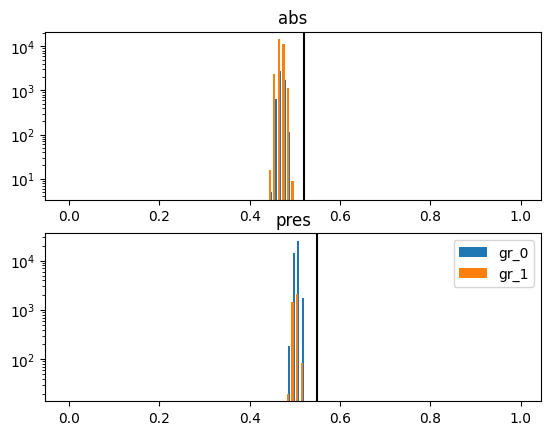

No improve counter : 64
item counter : 64
ratio : 0.9846153846153847
 ratio number predicted/items: 0.0
current epoch: 0


/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('no_improve_counter', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

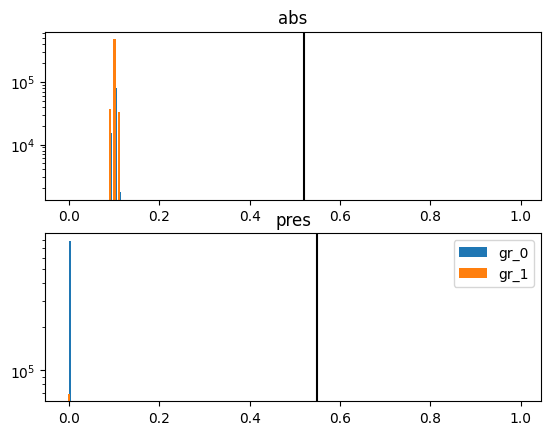

No improve counter : 1216
item counter : 1216
ratio : 0.9991783073130649
 ratio number predicted/items: 0.0
current epoch: 0


Validation: 0it [00:00, ?it/s]

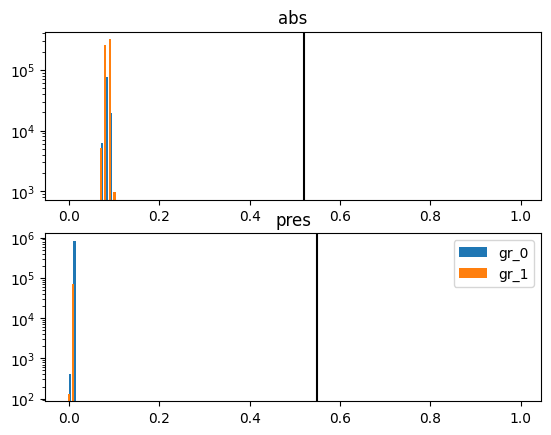

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 1


Validation: 0it [00:00, ?it/s]

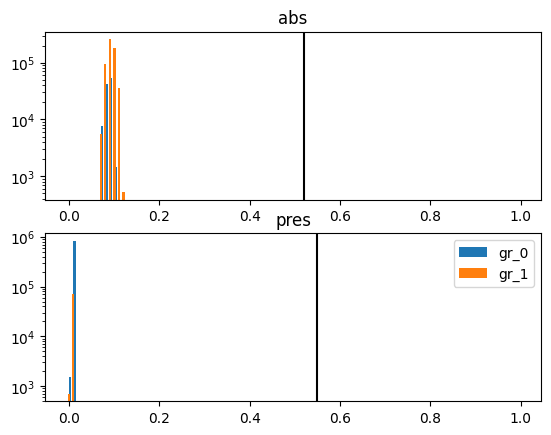

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 2


Validation: 0it [00:00, ?it/s]

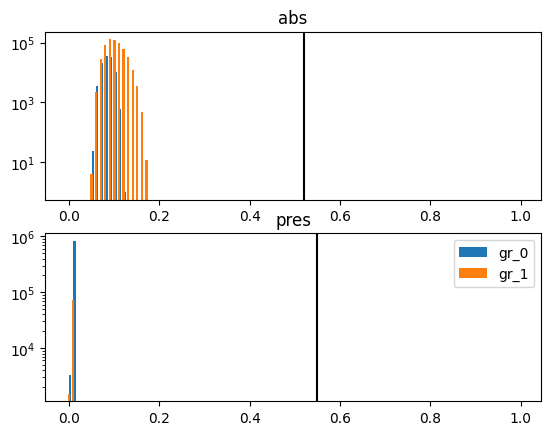

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 3


Validation: 0it [00:00, ?it/s]

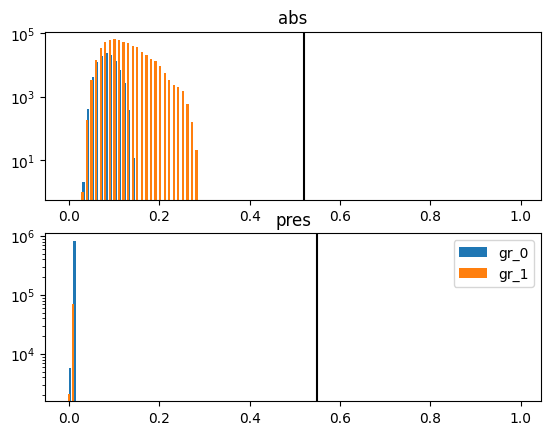

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 4


Validation: 0it [00:00, ?it/s]

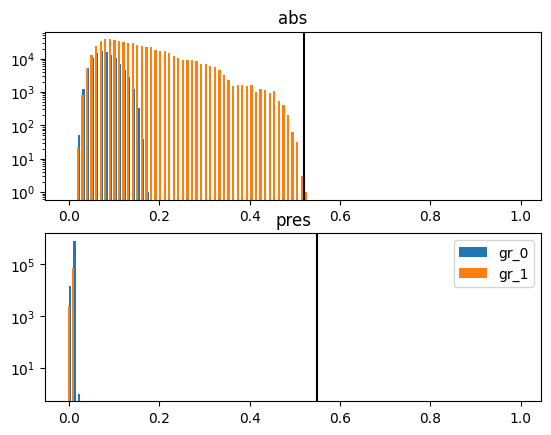

No improve counter : 1280
item counter : 1282
ratio : 0.9976617303195635
 ratio number predicted/items: 0.001558846453624318
current epoch: 5


Validation: 0it [00:00, ?it/s]

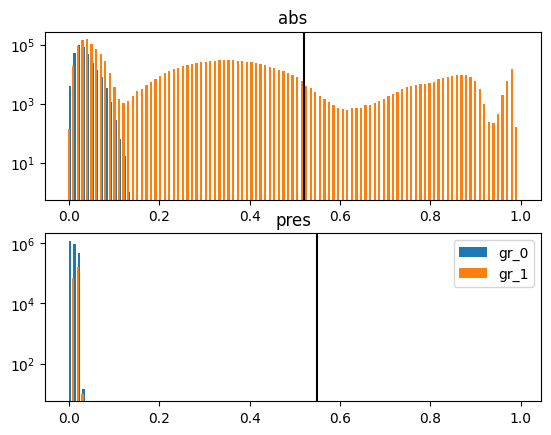

No improve counter : 1239
item counter : 4123
ratio : 0.3004364694471387
 ratio number predicted/items: 40.74272550921435
current epoch: 6


Validation: 0it [00:00, ?it/s]

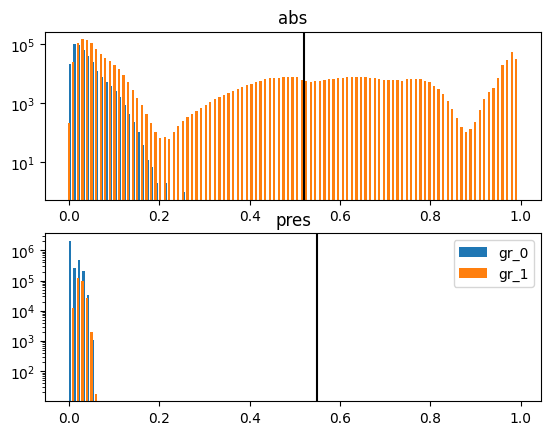

No improve counter : 1237
item counter : 4670
ratio : 0.2648255191607793
 ratio number predicted/items: 74.6859344894027
current epoch: 7


Validation: 0it [00:00, ?it/s]

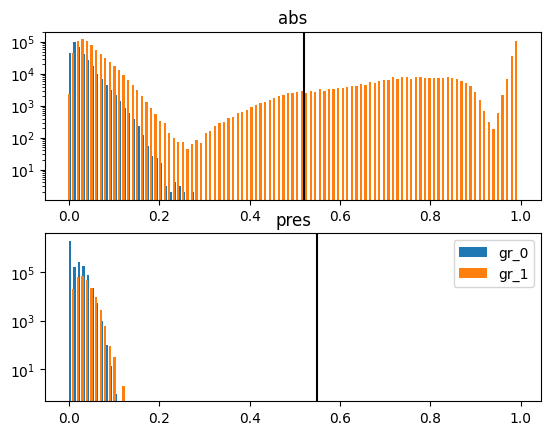

No improve counter : 1244
item counter : 4183
ratio : 0.29732313575525815
 ratio number predicted/items: 87.81477055449331
current epoch: 8


Validation: 0it [00:00, ?it/s]

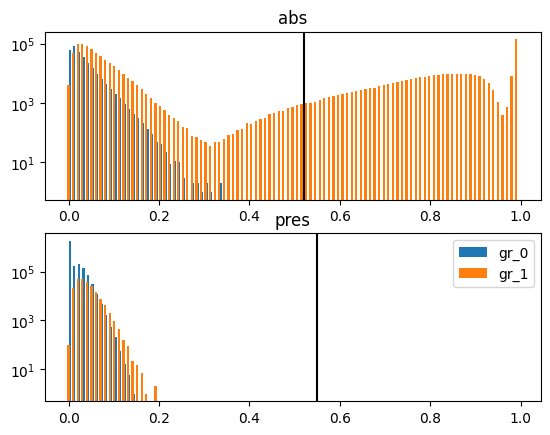

`Trainer.fit` stopped: `max_epochs=10` reached.


No improve counter : 1246
item counter : 3768
ratio : 0.3305916688776864
 ratio number predicted/items: 98.57283098965243
current epoch: 9


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory lightning_logs/version_81/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | net            | SmallNet          | 514   
1 | sym_preprocess | SymPreprocess     | 8.5 M 
2 | bcewll         | BCEWithLogitsLoss | 0     
3 | auroc          | BinaryAUROC       | 0     
-----------------------------------------------------
514       Trainable params
8.5 M     Non-trainable params
8.5 M     Total params
34.014    Total estimated model params size (MB)


1


Sanity Checking: 0it [00:00, ?it/s]

/tmp/ipykernel_3278/2863678930.py:187: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax1.set_yscale('log')
/tmp/ipykernel_3278/2863678930.py:193: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax2.set_yscale('log')


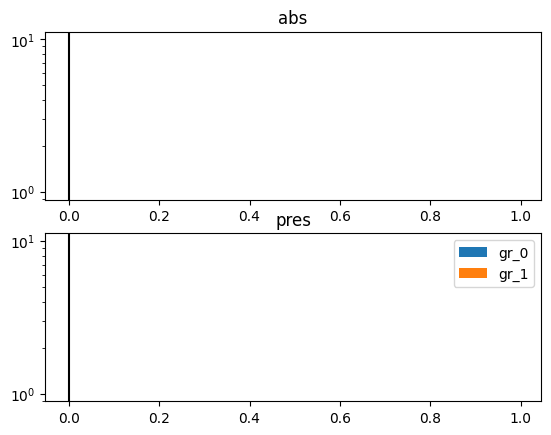

No improve counter : 0
item counter : 0
ratio : 0.0
 ratio number predicted/items: 0.0
current epoch: 0


Training: 0it [00:00, ?it/s]

/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/loops/optimization/automatic.py:129: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Validation: 0it [00:00, ?it/s]

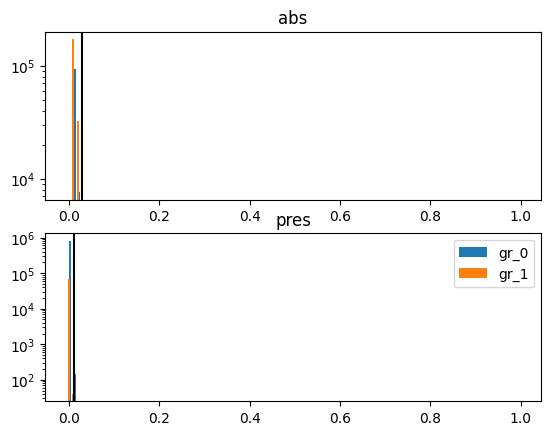

No improve counter : 1246
item counter : 1246
ratio : 0.9991980753809142
 ratio number predicted/items: 0.0
current epoch: 0


Validation: 0it [00:00, ?it/s]

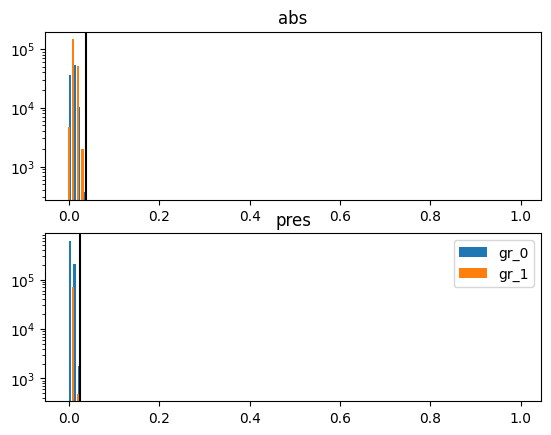

No improve counter : 1246
item counter : 1246
ratio : 0.9991980753809142
 ratio number predicted/items: 0.0
current epoch: 1


Validation: 0it [00:00, ?it/s]

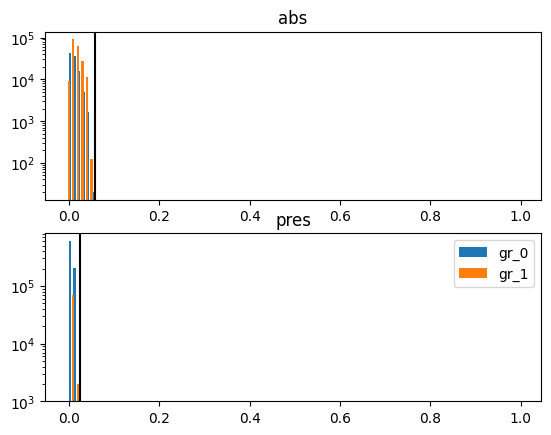

No improve counter : 1246
item counter : 1246
ratio : 0.9991980753809142
 ratio number predicted/items: 0.0
current epoch: 2


Validation: 0it [00:00, ?it/s]

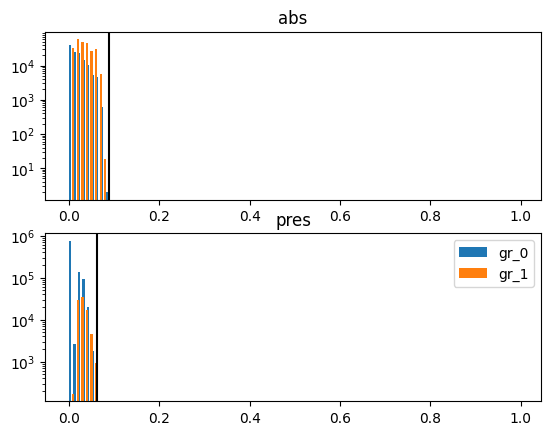

No improve counter : 1238
item counter : 1547
ratio : 0.7997416020671835
 ratio number predicted/items: 0.23772609819121446
current epoch: 3


Validation: 0it [00:00, ?it/s]

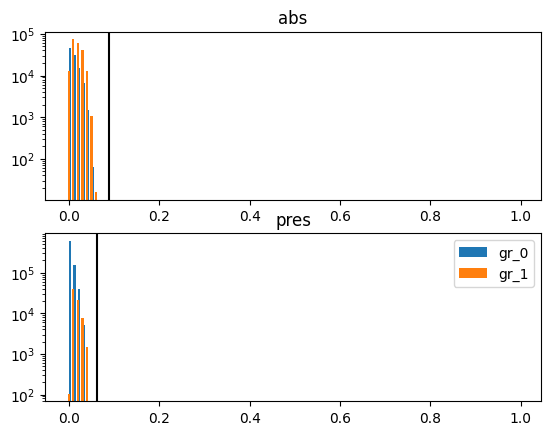

No improve counter : 1246
item counter : 1246
ratio : 0.9991980753809142
 ratio number predicted/items: 0.0
current epoch: 4


Validation: 0it [00:00, ?it/s]

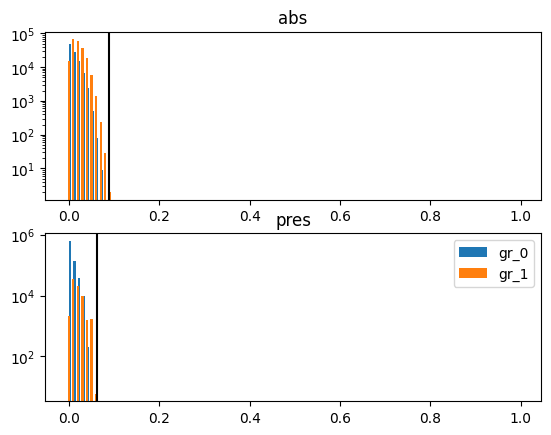

No improve counter : 1244
item counter : 1249
ratio : 0.9952
 ratio number predicted/items: 0.004
current epoch: 5


Validation: 0it [00:00, ?it/s]

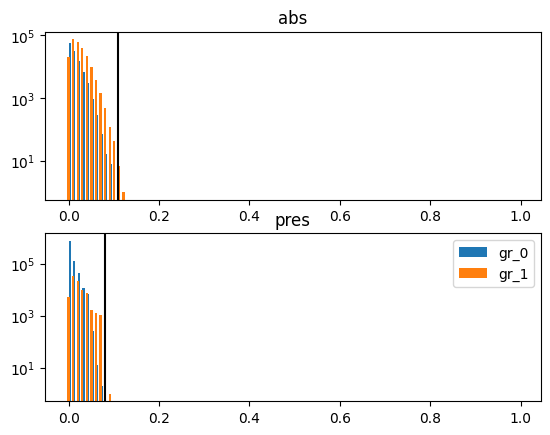

No improve counter : 1247
item counter : 1459
ratio : 0.8541095890410959
 ratio number predicted/items: 0.19726027397260273
current epoch: 6


Validation: 0it [00:00, ?it/s]

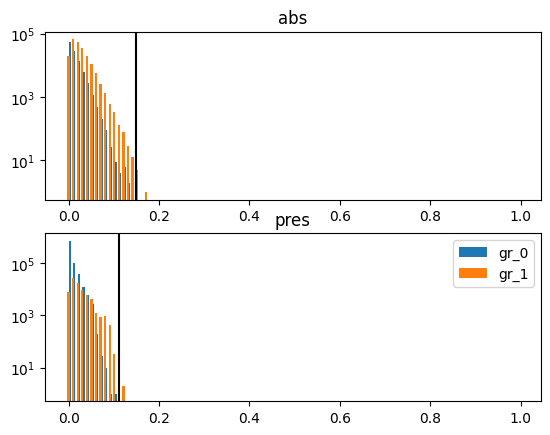

No improve counter : 1243
item counter : 1374
ratio : 0.904
 ratio number predicted/items: 0.12872727272727272
current epoch: 7


Validation: 0it [00:00, ?it/s]

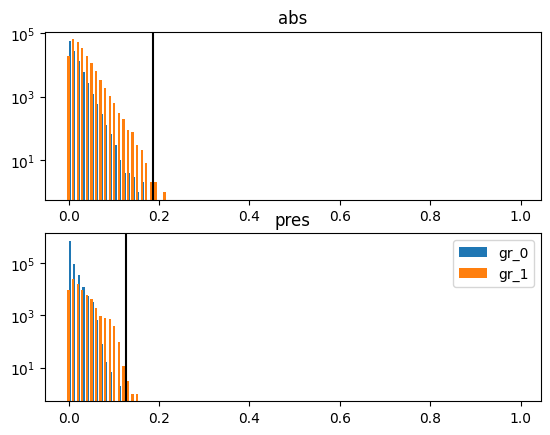

No improve counter : 1250
item counter : 1343
ratio : 0.9300595238095238
 ratio number predicted/items: 0.07514880952380952
current epoch: 8


Validation: 0it [00:00, ?it/s]

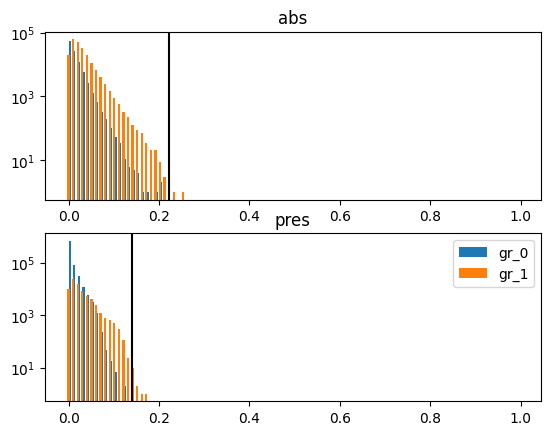

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | net            | SmallNet          | 514   
1 | sym_preprocess | SymPreprocess     | 8.5 M 
2 | bcewll         | BCEWithLogitsLoss | 0     
3 | auroc          | BinaryAUROC       | 0     
-----------------------------------------------------
514       Trainable params
8.5 M     Non-trainable params
8.5 M     Total params
34.014    Total estimated model params size (MB)


No improve counter : 1244
item counter : 1300
ratio : 0.9561875480399693
 ratio number predicted/items: 0.04688700999231361
current epoch: 9
2


Sanity Checking: 0it [00:00, ?it/s]

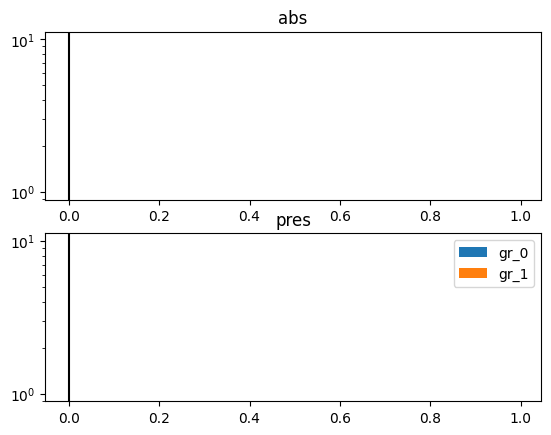

No improve counter : 0
item counter : 0
ratio : 0.0
 ratio number predicted/items: 0.0
current epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

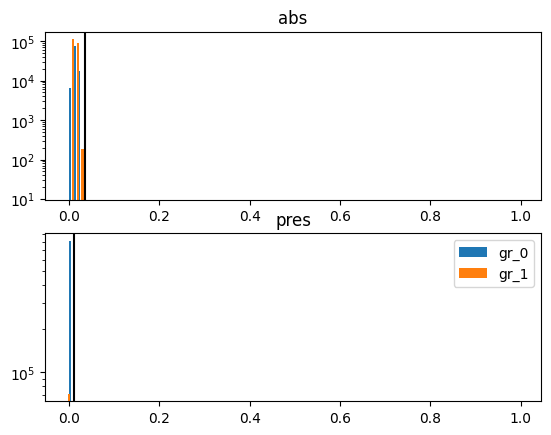

No improve counter : 1253
item counter : 1253
ratio : 0.9992025518341308
 ratio number predicted/items: 0.0
current epoch: 0


Validation: 0it [00:00, ?it/s]

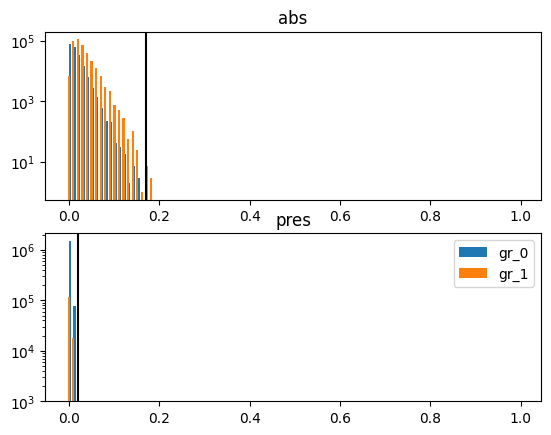

No improve counter : 1230
item counter : 2443
ratio : 0.5032733224222586
 ratio number predicted/items: 0.6550736497545008
current epoch: 1


Validation: 0it [00:00, ?it/s]

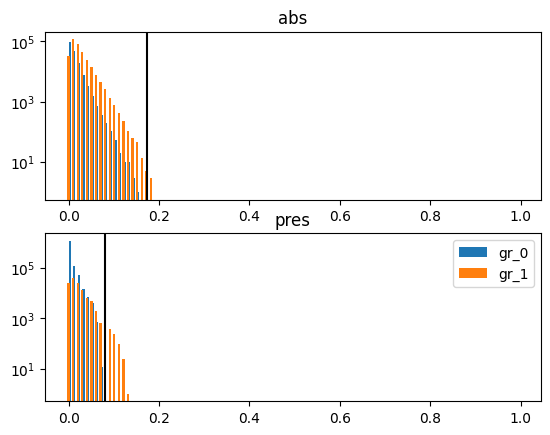

No improve counter : 1240
item counter : 2154
ratio : 0.5754060324825986
 ratio number predicted/items: 0.5610208816705337
current epoch: 2


Validation: 0it [00:00, ?it/s]

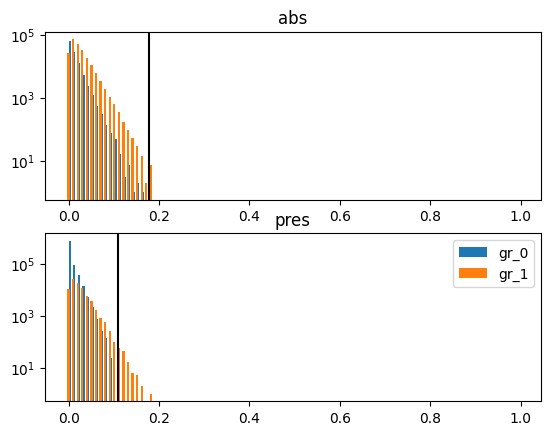

No improve counter : 1248
item counter : 1397
ratio : 0.8927038626609443
 ratio number predicted/items: 0.1223175965665236
current epoch: 3


Validation: 0it [00:00, ?it/s]

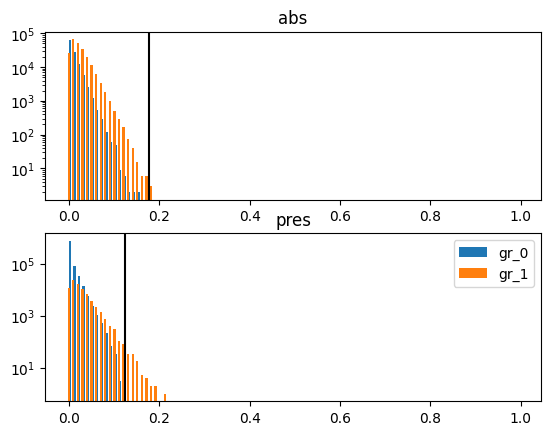

No improve counter : 1240
item counter : 1388
ratio : 0.8927285817134629
 ratio number predicted/items: 0.11879049676025918
current epoch: 4


Validation: 0it [00:00, ?it/s]

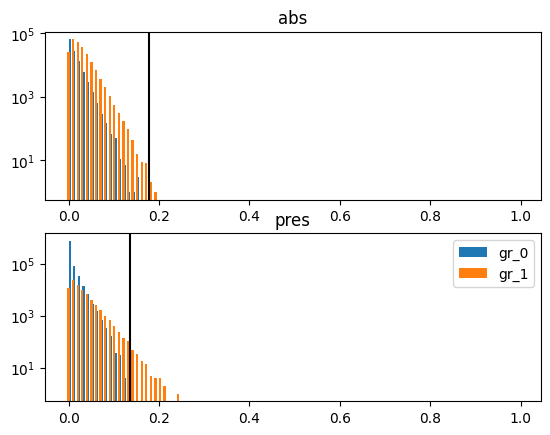

No improve counter : 1248
item counter : 1418
ratio : 0.879492600422833
 ratio number predicted/items: 0.1324876673713883
current epoch: 5


Validation: 0it [00:00, ?it/s]

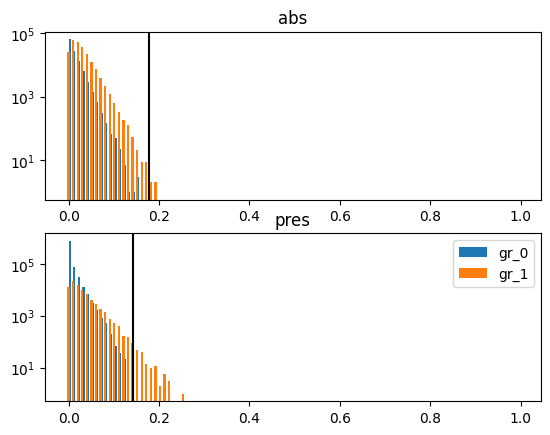

No improve counter : 1242
item counter : 1457
ratio : 0.8518518518518519
 ratio number predicted/items: 0.16255144032921812
current epoch: 6


Validation: 0it [00:00, ?it/s]

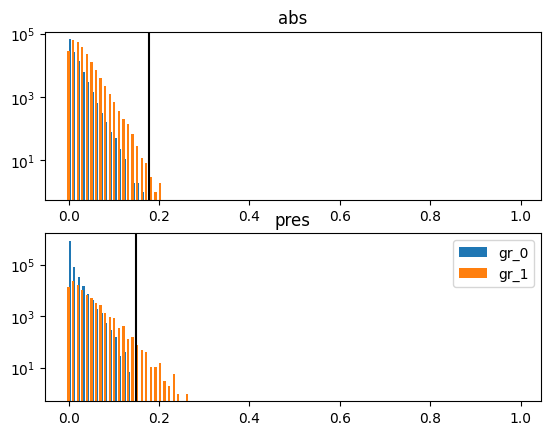

No improve counter : 1236
item counter : 1495
ratio : 0.8262032085561497
 ratio number predicted/items: 0.1945187165775401
current epoch: 7


Validation: 0it [00:00, ?it/s]

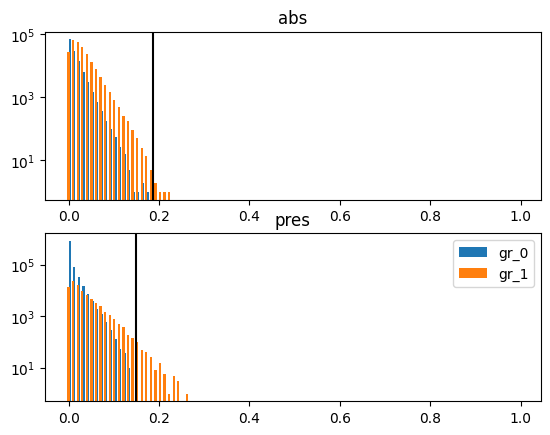

No improve counter : 1236
item counter : 1515
ratio : 0.8153034300791556
 ratio number predicted/items: 0.2091029023746702
current epoch: 8


Validation: 0it [00:00, ?it/s]

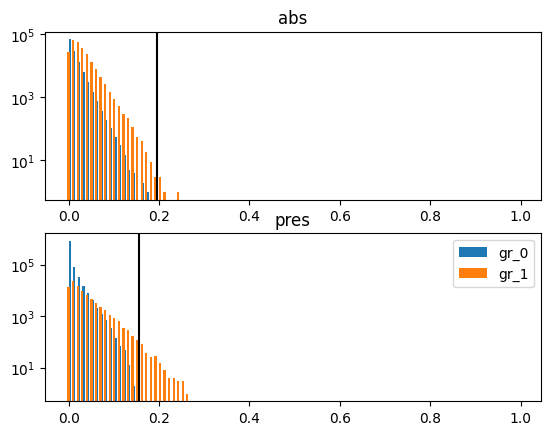

No improve counter : 1240
item counter : 1511
ratio : 0.8201058201058201
 ratio number predicted/items: 0.207010582010582
current epoch: 9


Validation: 0it [00:00, ?it/s]

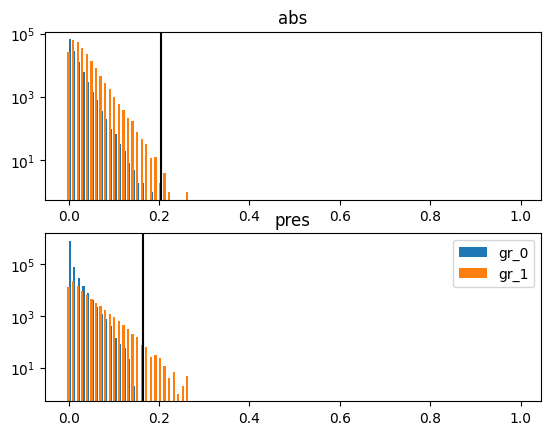

No improve counter : 1243
item counter : 1467
ratio : 0.8467302452316077
 ratio number predicted/items: 0.17506811989100818
current epoch: 10


Validation: 0it [00:00, ?it/s]

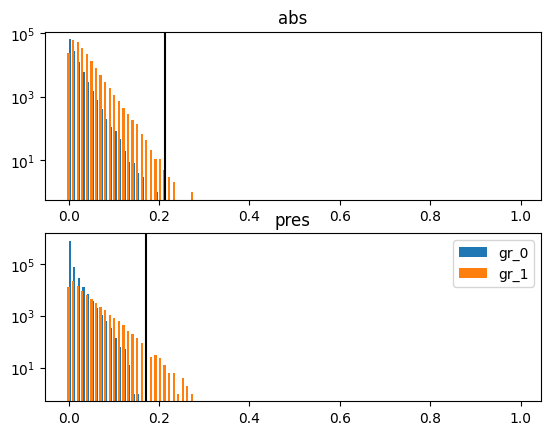

No improve counter : 1235
item counter : 1420
ratio : 0.8691062631949331
 ratio number predicted/items: 0.14567206192821958
current epoch: 11


Validation: 0it [00:00, ?it/s]

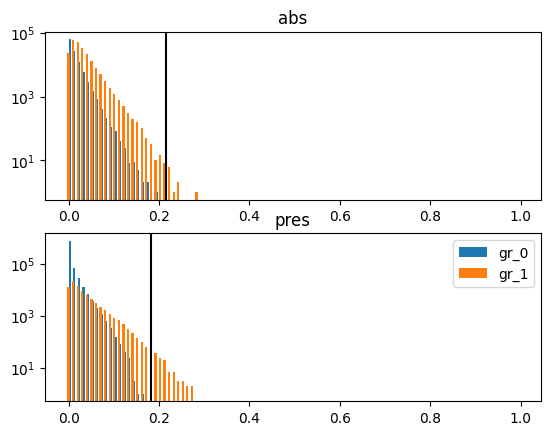

No improve counter : 1236
item counter : 1402
ratio : 0.8809693513898789
 ratio number predicted/items: 0.12972202423378476
current epoch: 12


Validation: 0it [00:00, ?it/s]

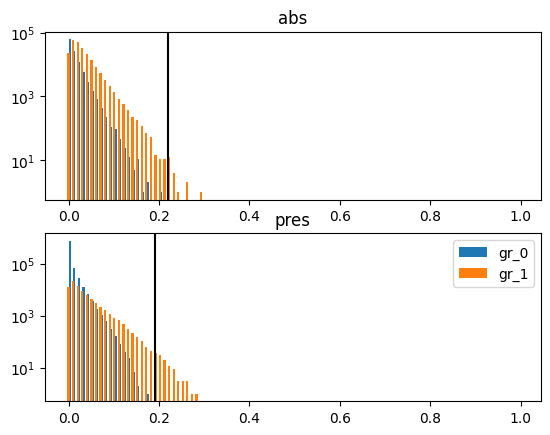

No improve counter : 1241
item counter : 1387
ratio : 0.8940922190201729
 ratio number predicted/items: 0.11455331412103746
current epoch: 13


Validation: 0it [00:00, ?it/s]

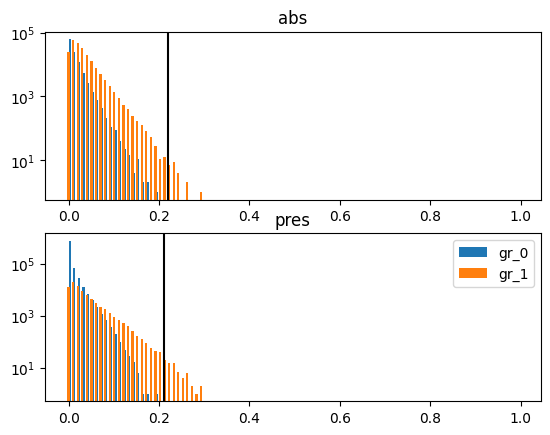

No improve counter : 1239
item counter : 1356
ratio : 0.9130434782608695
 ratio number predicted/items: 0.09285187914517318
current epoch: 14


Validation: 0it [00:00, ?it/s]

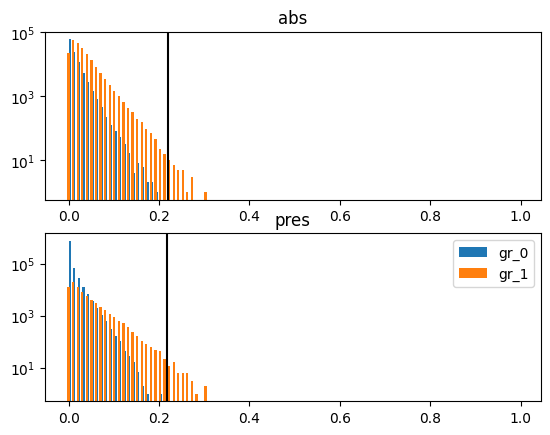

No improve counter : 1247
item counter : 1338
ratio : 0.9312920089619119
 ratio number predicted/items: 0.07318894697535475
current epoch: 15


Validation: 0it [00:00, ?it/s]

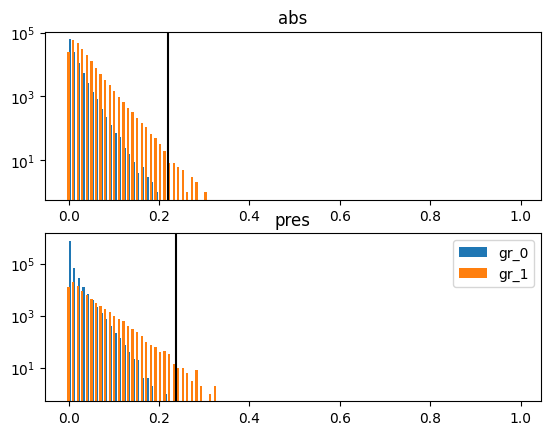

No improve counter : 1246
item counter : 1343
ratio : 0.9270833333333334
 ratio number predicted/items: 0.07738095238095238
current epoch: 16


Validation: 0it [00:00, ?it/s]

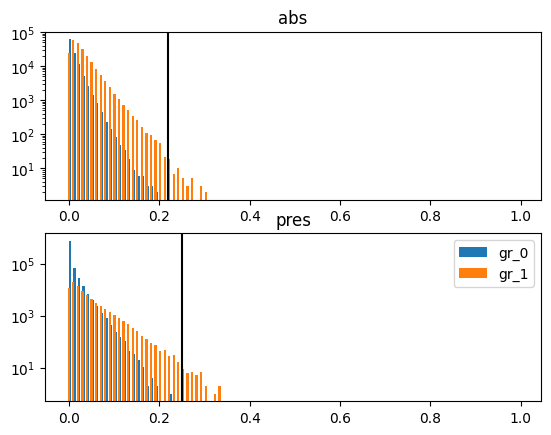

No improve counter : 1238
item counter : 1337
ratio : 0.9252615844544095
 ratio number predicted/items: 0.08146487294469357
current epoch: 17


Validation: 0it [00:00, ?it/s]

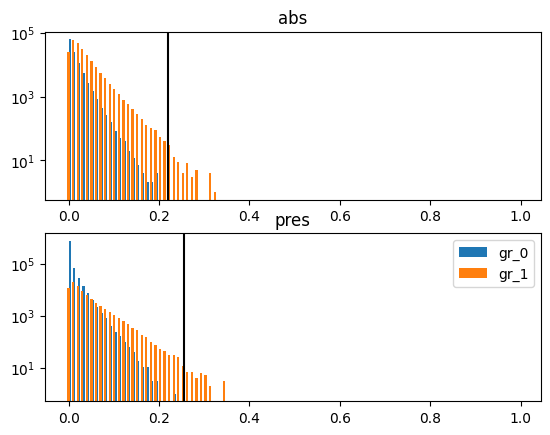

No improve counter : 1242
item counter : 1361
ratio : 0.9118942731277533
 ratio number predicted/items: 0.09618208516886931
current epoch: 18


Validation: 0it [00:00, ?it/s]

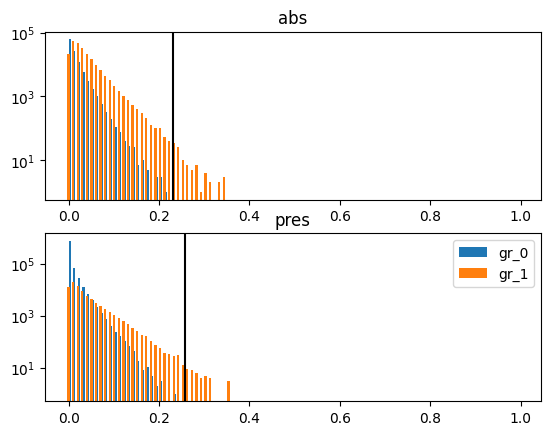

`Trainer.fit` stopped: `max_epochs=20` reached.


No improve counter : 1241
item counter : 1393
ratio : 0.8902439024390244
 ratio number predicted/items: 0.12697274031563846
current epoch: 19


In [17]:
prev_nets= []
for i in range(3):
    model_checkpoint = ModelCheckpoint(monitor='ratio_number_predicted_per_items', mode='max')
    trainer = pl.Trainer(
    max_epochs=20 if i==2 else 10,
#     max_epochs=40,
    accelerator='gpu',
    devices=1,
    log_every_n_steps=1,
    # logger=pl.loggers.CSVLogger(save_dir="logs/"),
    reload_dataloaders_every_n_epochs=1,
    logger=tensorboard,
    callbacks=[model_checkpoint]
    )
    print(i)
    model = SudokuLightning(
        lr=0.01,
        prev_nets=prev_nets,
        coef_0 = 10 if i==0 else 20,
    )
    _ = trainer.fit(model,)
#     model.below_threshold_coef=0.9
#     model = model.load_from_checkpoint(model_checkpoint.best_model_path)
#     print(model_checkpoint.best_model_path)
#     trainer.validate(model=model)
#     if trainer.logged_metrics['no_improve_counter'].item()==0:
    prev_nets.append((model.net, (model.threshold_abs, model.threshold_pres)))
    

In [18]:
import joblib
dump_list = []
for i, (prev_net, (th_abs, th_pres) )in enumerate(prev_nets):
    net_name = f"net_{i}"
    torch.save(prev_net.state_dict(), net_name)
    dump_list.append((net_name,(th_abs, th_pres)))
joblib.dump(dump_list, "thresholds.dump")

['thresholds.dump']

In [ ]:

# trainer = pl.Trainer(
#     max_epochs=20,
# #     max_epochs=40,
#     accelerator='gpu',
#     devices=1,
#     log_every_n_steps=1,
#     # logger=pl.loggers.CSVLogger(save_dir="logs/"),
#     reload_dataloaders_every_n_epochs=1,
#     logger=tensorboard,
#     callbacks=[model_checkpoint]
# )
# model = DistillationLightning(
#         lr=0.01,
#         prev_nets=prev_nets,
#         coef_0 = 2,
#     )
# _ = trainer.fit(model,)

In [ ]:
# for i in range(3):
#     model_checkpoint = ModelCheckpoint(monitor='no_improve_counter')
#     trainer = pl.Trainer(
#     max_epochs=20,
#     accelerator='gpu',
#     devices=1,
#     log_every_n_steps=1,
#     # logger=pl.loggers.CSVLogger(save_dir="logs/"),
#     reload_dataloaders_every_n_epochs=1,
#     logger=tensorboard,
#     callbacks=[model_checkpoint]
#     )
#     print(i)
#     model = SudokuLightning(lr=0.01, prev_nets=prev_nets)
#     _ = trainer.fit(model,)
# #     model = model.load_from_checkpoint(model_checkpoint.best_model_path)
# #     trainer.validate(model=model)
#     prev_nets.append((model.net, (model.threshold_abs, model.threshold_pres)))

In [19]:
model.no_improve_counter

0

In [20]:
len(prev_nets)

3

In [21]:
from copy import copy

def predict_from_net(x, net, th_abs, th_pres):
    x = model.sym_preprocess.forward(x)
    x = net(x)
    new_x = torch.empty(x.shape, device=x.device)
    new_x[:,0] = (x[:,0] > th_abs).float()
    new_x[:,1] = (x[:,1] > th_pres).float()
    return new_x

def predict_fix_from_net(x, y,  net, th_abs, th_pres):
    
    output = model.sym_preprocess.forward(x)
    output = net(output)
    new_x = torch.empty(x.shape, device=x.device)
    new_x[:,0] = (output[:,0] > th_abs).float()
    new_x[:,1] = (output[:,1] > th_pres).float()
    max_th_abs = output[:,0][(x[:,0]==0)&(y[:,0]==0)].max().item()
    max_th_pres = output[:,1][(x[:,1]==0)&(y[:,1]==0)].max().item()
    
    return new_x, max(th_abs, max_th_abs), max(th_pres, max_th_pres)


def forward_from_prev_nets(x,y):

    for net, (th_abs, th_pres) in prev_nets:
        new_x = torch.zeros(x.shape, device=x.device)
        with torch.no_grad():
            sub_new_x = predict_from_net(x, net.to(x.device), th_abs, th_pres)
        new_x[sub_new_x==1]=1
        new_x[x==1]=1
        print(f"errrors: {((new_x==1)&(y==0)).sum()}")
        new_x[(new_x==1)&(y==0)]=0
        if new_x.sum(dim=(1,2))>x.sum(dim=(1,2)):
            break
        x = new_x
    return new_x


def forward_from_prev_nets_all(x,y, prev_nets=prev_nets, raise_if_error=False, fix=False, full_loop=True):
    
    for i,(net, (th_abs, th_pres)) in enumerate(prev_nets):
        new_x = torch.zeros(x.shape, device=x.device)
        with torch.no_grad():
            if fix:
                sub_new_x, new_th_abs, new_th_pres = predict_fix_from_net(x, y, net.to(x.device), th_abs, th_pres)
                if (new_th_abs != th_abs) or (new_th_pres != th_pres):
                    prev_nets[i] = (net, (new_th_abs, new_th_pres))
            else:
                sub_new_x = predict_from_net(x, net.to(x.device), th_abs, th_pres)
        new_x[sub_new_x==1]=1
        new_x[x==1]=1
        n_errors = ((new_x==1)&(y==0)).sum(dim=(0,2))
        # print(f"errrors: {n_errors}")
        if n_errors.sum()>0:
            print(f"found errors : {n_errors}")
            print(f"model index : {i}")
            if raise_if_error:
                raise ValueError
        new_x[(new_x==1)&(y==0)]=0
        if new_x.sum()> x.sum() and not full_loop:
            break
        x = new_x
    return new_x

def fix_threshold(x,y,prev_nets, margin=0.05):
    x_feature = model.sym_preprocess.forward(x)
    new_prev_nets = []
    for net, (th_abs, th_pres) in prev_nets:
        
        output = net(x_feature)       
        max_th_abs = output[:,0][(x[:,0]==0)&(y[:,0]==0)].max().item()
        if th_abs < max_th_abs+margin:
            th_abs = max_th_abs+margin
        max_th_pres = output[:,1][(x[:,1]==0)&(y[:,1]==0)].max().item()
        if th_pres < max_th_pres+margin:
            th_pres = max_th_pres+margin  
        new_prev_nets.append((net, (th_abs, th_pres)))
    return new_prev_nets

In [22]:
print(test_x.sum())
print(test_x[:,1].sum())
display_as_dataframe(test_x)

tensor(234.)
tensor(26.)


In [23]:
new_x = forward_from_prev_nets_all(test_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(535.)
tensor(26.)


In [24]:
prev_x = new_x.clone()
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(540.)
tensor(26.)


In [25]:
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(540.)
tensor(26.)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory lightning_logs/version_81/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | net            | SmallNet          | 514   
1 | sym_preprocess | SymPreprocess     | 8.5 M 
2 | bcewll         | BCEWithLogitsLoss | 0     
3 | auroc      

0


Sanity Checking: 0it [00:00, ?it/s]

/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/tmp/ipykernel_3278/2863678930.py:187: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax1.set_yscale('log')
/tmp/ipykernel_3278/2863678930.py:193: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax2.set_yscale('log')


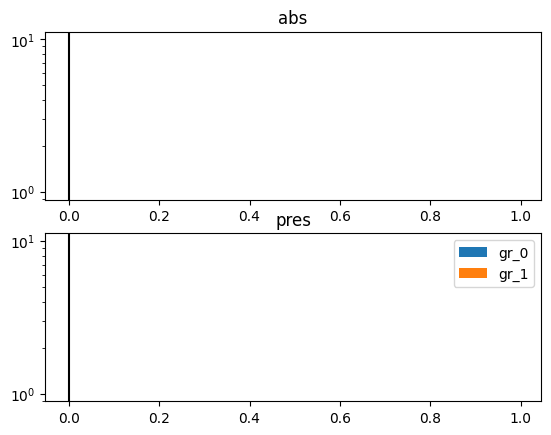

No improve counter : 0
item counter : 0
ratio : 0.0
 ratio number predicted/items: 0.0
current epoch: 0


/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

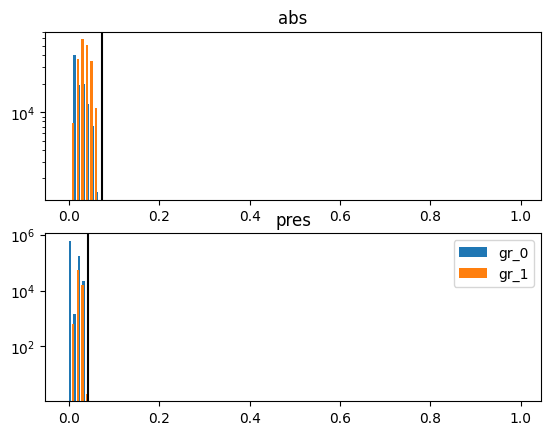

No improve counter : 1241
item counter : 1241
ratio : 0.999194847020934
 ratio number predicted/items: 0.0
current epoch: 0


Validation: 0it [00:00, ?it/s]

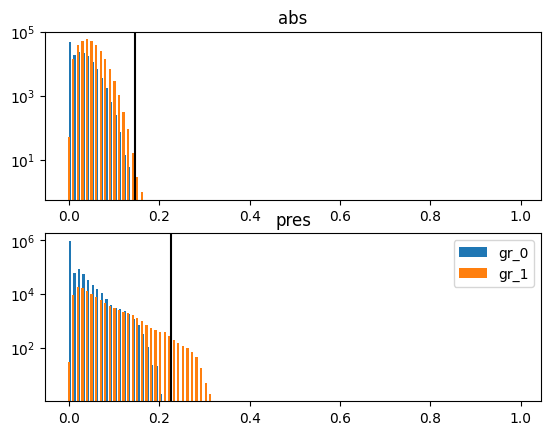

No improve counter : 1237
item counter : 1916
ratio : 0.6452790818988002
 ratio number predicted/items: 0.48982785602503914
current epoch: 1


Validation: 0it [00:00, ?it/s]

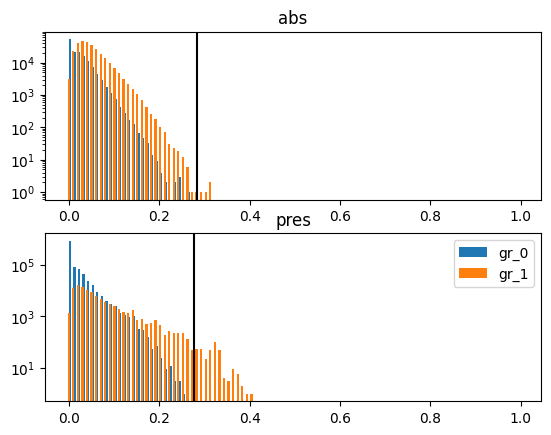

No improve counter : 1239
item counter : 1744
ratio : 0.710028653295129
 ratio number predicted/items: 0.39140401146131804
current epoch: 2


Validation: 0it [00:00, ?it/s]

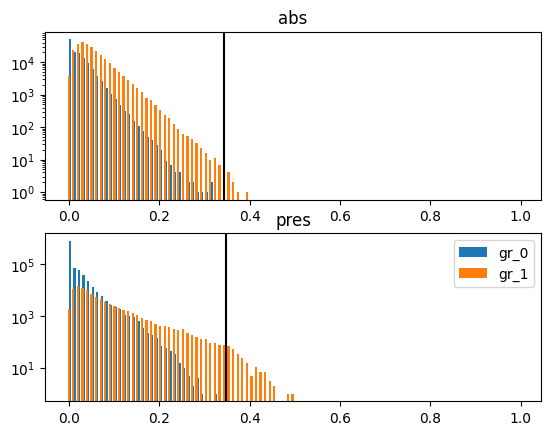

No improve counter : 1239
item counter : 1607
ratio : 0.7705223880597015
 ratio number predicted/items: 0.2916666666666667
current epoch: 3


Validation: 0it [00:00, ?it/s]

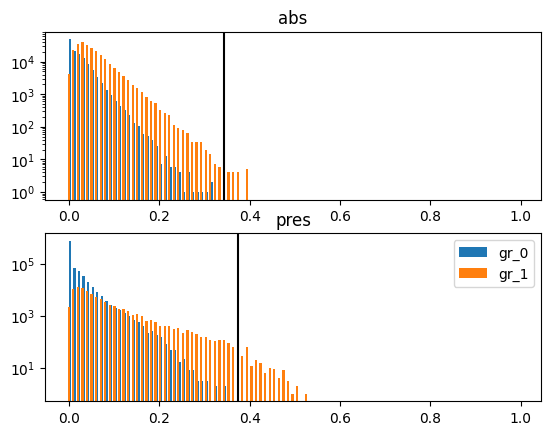

No improve counter : 1241
item counter : 1515
ratio : 0.8186015831134564
 ratio number predicted/items: 0.20976253298153033
current epoch: 4


Validation: 0it [00:00, ?it/s]

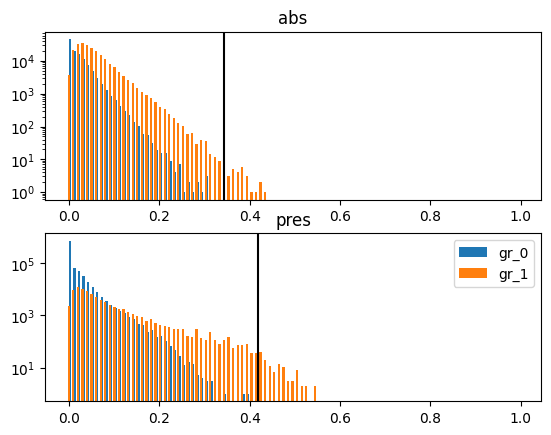

No improve counter : 1247
item counter : 1436
ratio : 0.8677800974251914
 ratio number predicted/items: 0.14474599860821155
current epoch: 5


Validation: 0it [00:00, ?it/s]

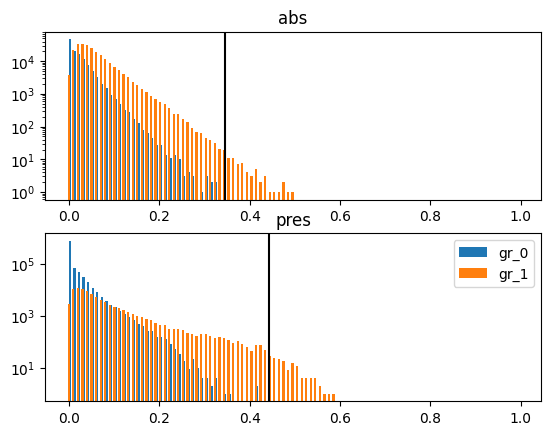

No improve counter : 1245
item counter : 1462
ratio : 0.8509911141490089
 ratio number predicted/items: 0.1674641148325359
current epoch: 6


Validation: 0it [00:00, ?it/s]

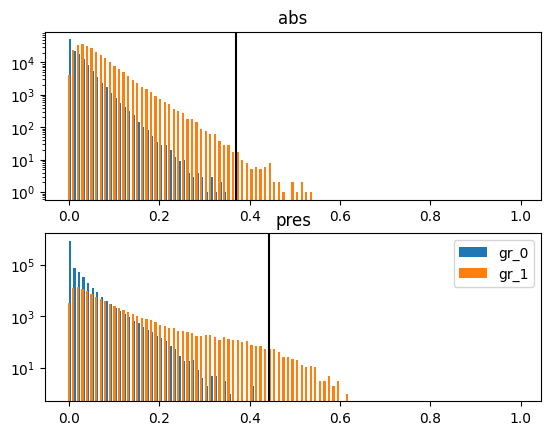

No improve counter : 1239
item counter : 1611
ratio : 0.7686104218362283
 ratio number predicted/items: 0.2698511166253102
current epoch: 7


Validation: 0it [00:00, ?it/s]

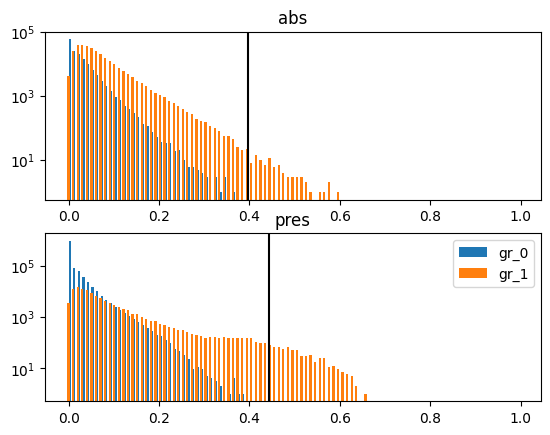

No improve counter : 1227
item counter : 1863
ratio : 0.6582618025751072
 ratio number predicted/items: 0.44206008583690987
current epoch: 8


Validation: 0it [00:00, ?it/s]

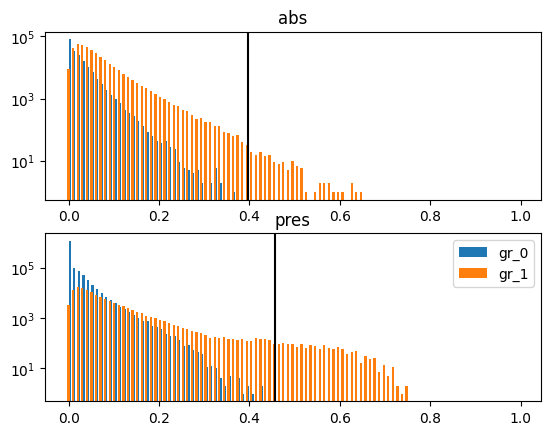

`Trainer.fit` stopped: `max_epochs=10` reached.


No improve counter : 1238
item counter : 2324
ratio : 0.5324731182795699
 ratio number predicted/items: 0.7445161290322581
current epoch: 9


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | net            | SmallNet          | 514   
1 | sym_preprocess | SymPreprocess     | 8.5 M 
2 | bcewll         | BCEWithLogitsLoss | 0     
3 | auroc          | BinaryAUROC       | 0     
-----------------------------------------------------
514       Trainable params
8.5 M     Non-trainable params
8.5 M     Total params
34.014    Total estimated model params size (MB)


1


Sanity Checking: 0it [00:00, ?it/s]

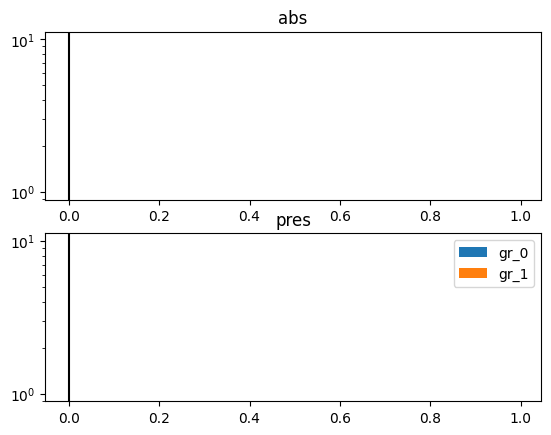

No improve counter : 0
item counter : 0
ratio : 0.0
 ratio number predicted/items: 0.0
current epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

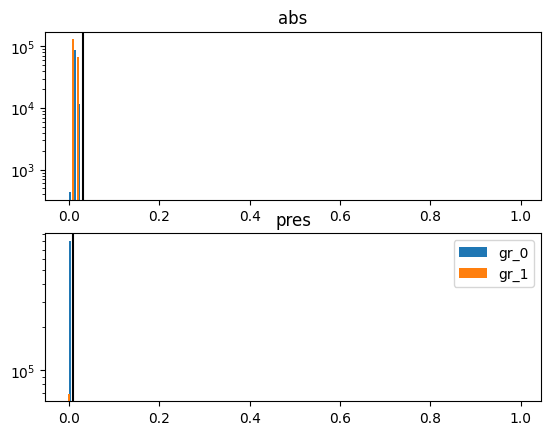

No improve counter : 1241
item counter : 1241
ratio : 0.999194847020934
 ratio number predicted/items: 0.0
current epoch: 0


Validation: 0it [00:00, ?it/s]

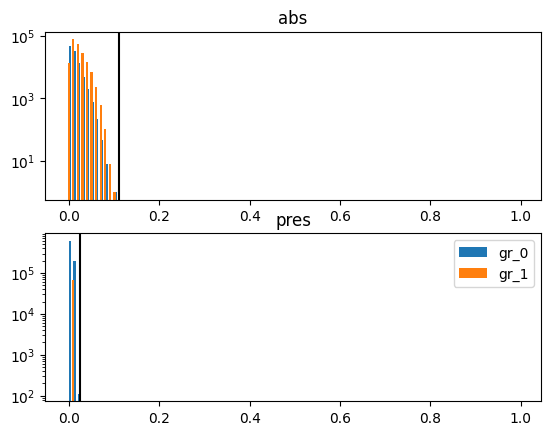

No improve counter : 1240
item counter : 1250
ratio : 0.991207034372502
 ratio number predicted/items: 0.011990407673860911
current epoch: 1


Validation: 0it [00:00, ?it/s]

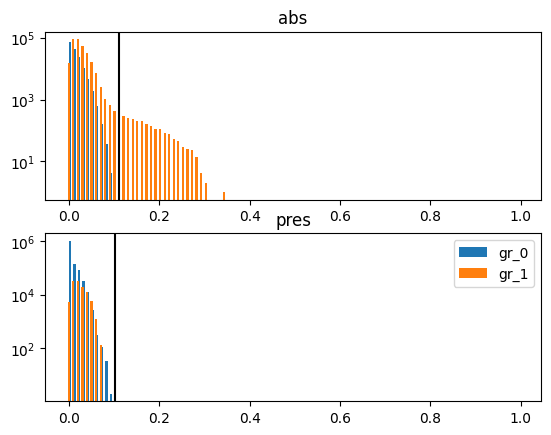

No improve counter : 1230
item counter : 1996
ratio : 0.6159238858287431
 ratio number predicted/items: 1.1832749123685529
current epoch: 2


Validation: 0it [00:00, ?it/s]

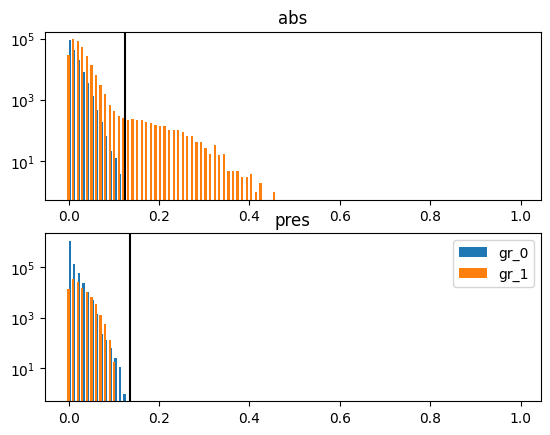

No improve counter : 1240
item counter : 2019
ratio : 0.6138613861386139
 ratio number predicted/items: 1.3925742574257425
current epoch: 3


Validation: 0it [00:00, ?it/s]

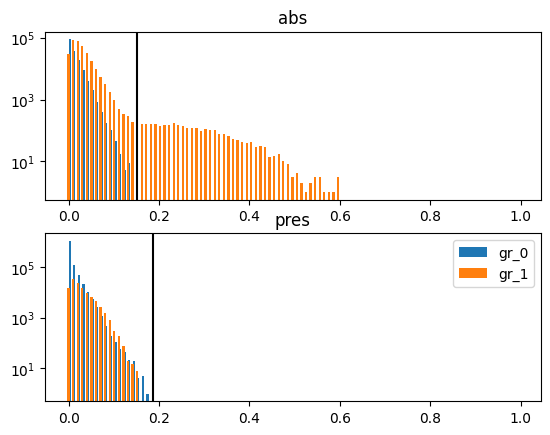

No improve counter : 1234
item counter : 2037
ratio : 0.60549558390579
 ratio number predicted/items: 1.5500490677134446
current epoch: 4


Validation: 0it [00:00, ?it/s]

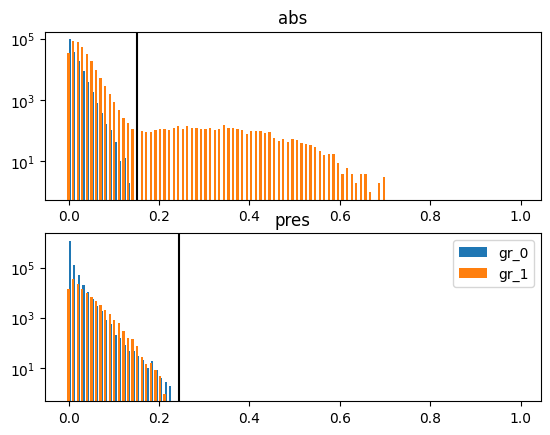

No improve counter : 1239
item counter : 2104
ratio : 0.5885985748218527
 ratio number predicted/items: 1.8498812351543943
current epoch: 5


Validation: 0it [00:00, ?it/s]

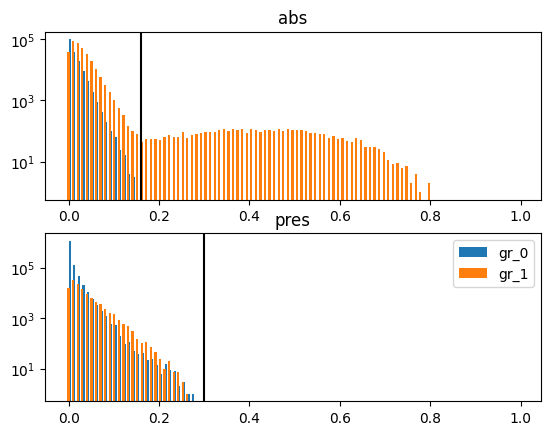

No improve counter : 1233
item counter : 2172
ratio : 0.5674183156925909
 ratio number predicted/items: 1.9829728485964104
current epoch: 6


Validation: 0it [00:00, ?it/s]

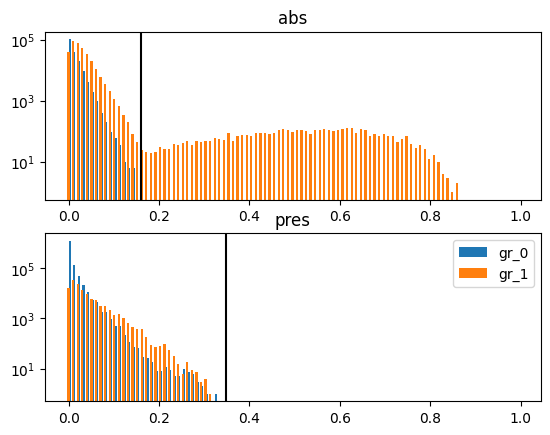

No improve counter : 1233
item counter : 2215
ratio : 0.5564079422382672
 ratio number predicted/items: 2.046028880866426
current epoch: 7


Validation: 0it [00:00, ?it/s]

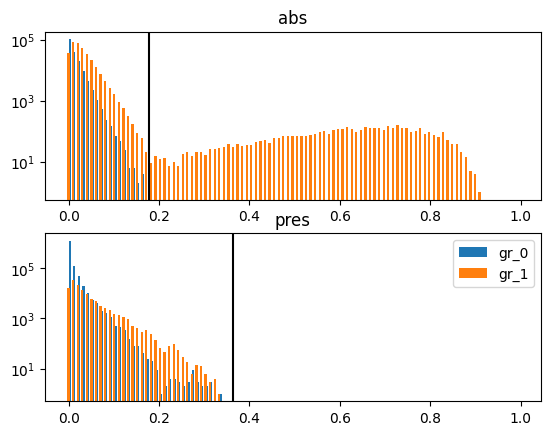

No improve counter : 1235
item counter : 2242
ratio : 0.5506018724921979
 ratio number predicted/items: 2.0789121711992866
current epoch: 8


Validation: 0it [00:00, ?it/s]

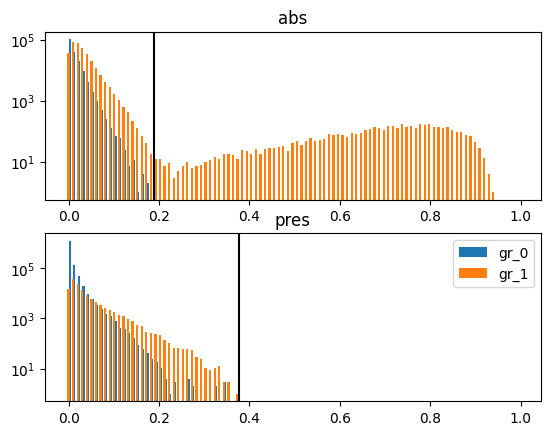

`Trainer.fit` stopped: `max_epochs=10` reached.


No improve counter : 1235
item counter : 2253
ratio : 0.5479148181011535
 ratio number predicted/items: 2.0940550133096716
current epoch: 9


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | net            | SmallNet          | 514   
1 | sym_preprocess | SymPreprocess     | 8.5 M 
2 | bcewll         | BCEWithLogitsLoss | 0     
3 | auroc          | BinaryAUROC       | 0     
-----------------------------------------------------
514       Trainable params
8.5 M     Non-trainable params
8.5 M     Total params
34.014    Total estimated model params size (MB)


2


Sanity Checking: 0it [00:00, ?it/s]

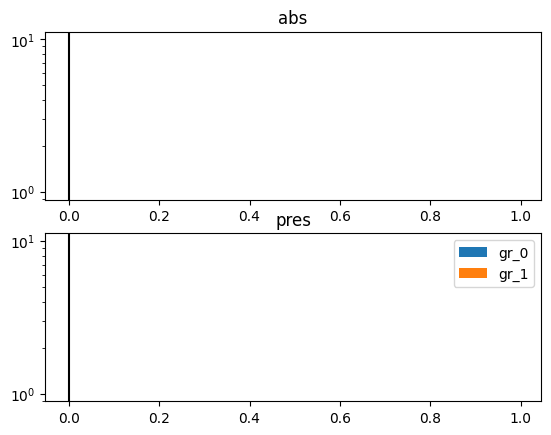

No improve counter : 0
item counter : 0
ratio : 0.0
 ratio number predicted/items: 0.0
current epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

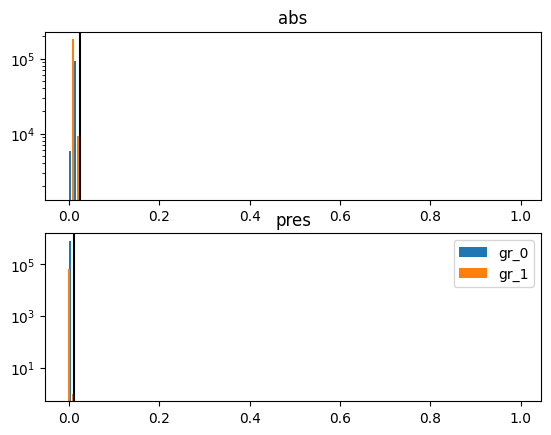

No improve counter : 1232
item counter : 1232
ratio : 0.9991889699918897
 ratio number predicted/items: 0.0
current epoch: 0


Validation: 0it [00:00, ?it/s]

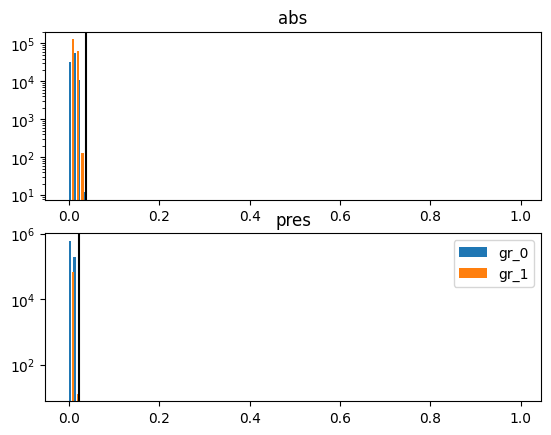

No improve counter : 1232
item counter : 1232
ratio : 0.9991889699918897
 ratio number predicted/items: 0.0
current epoch: 1


Validation: 0it [00:00, ?it/s]

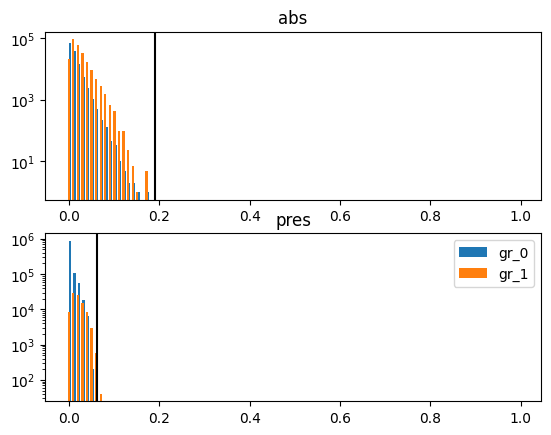

No improve counter : 1234
item counter : 1637
ratio : 0.7533577533577533
 ratio number predicted/items: 0.3076923076923077
current epoch: 2


Validation: 0it [00:00, ?it/s]

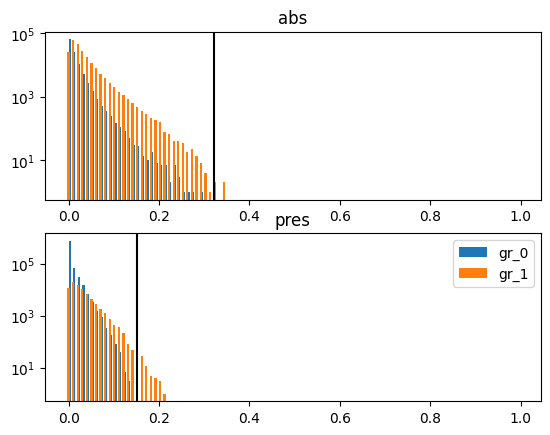

No improve counter : 1230
item counter : 1408
ratio : 0.872959545777147
 ratio number predicted/items: 0.1547196593328602
current epoch: 3


Validation: 0it [00:00, ?it/s]

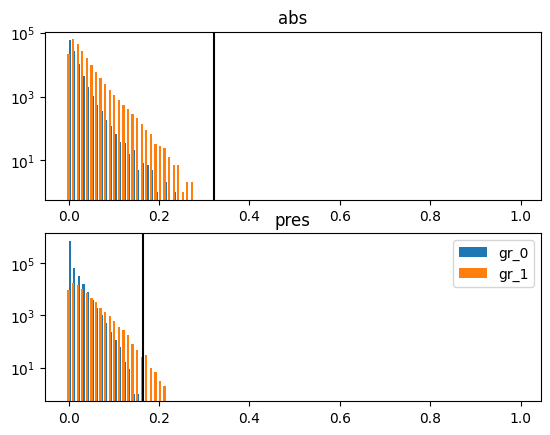

No improve counter : 1235
item counter : 1309
ratio : 0.9427480916030534
 ratio number predicted/items: 0.061068702290076333
current epoch: 4


Validation: 0it [00:00, ?it/s]

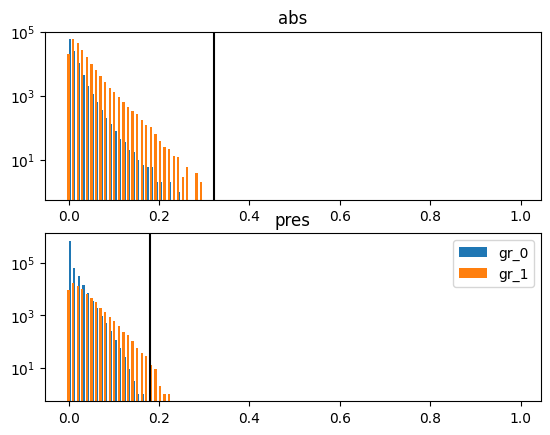

No improve counter : 1232
item counter : 1270
ratio : 0.969315499606609
 ratio number predicted/items: 0.03225806451612903
current epoch: 5


Validation: 0it [00:00, ?it/s]

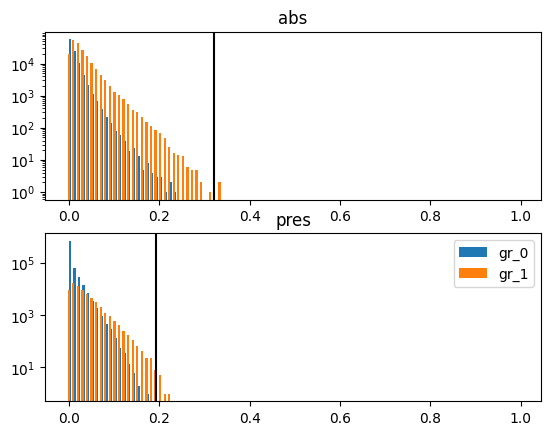

No improve counter : 1236
item counter : 1257
ratio : 0.9825119236883942
 ratio number predicted/items: 0.018282988871224166
current epoch: 6


Validation: 0it [00:00, ?it/s]

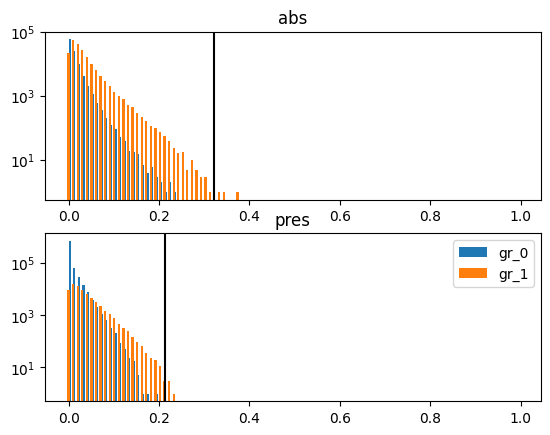

No improve counter : 1240
item counter : 1258
ratio : 0.9849086576648134
 ratio number predicted/items: 0.015885623510722795
current epoch: 7


Validation: 0it [00:00, ?it/s]

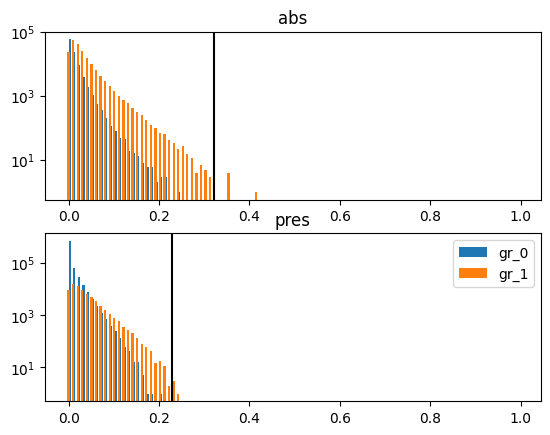

No improve counter : 1233
item counter : 1247
ratio : 0.9879807692307693
 ratio number predicted/items: 0.01201923076923077
current epoch: 8


Validation: 0it [00:00, ?it/s]

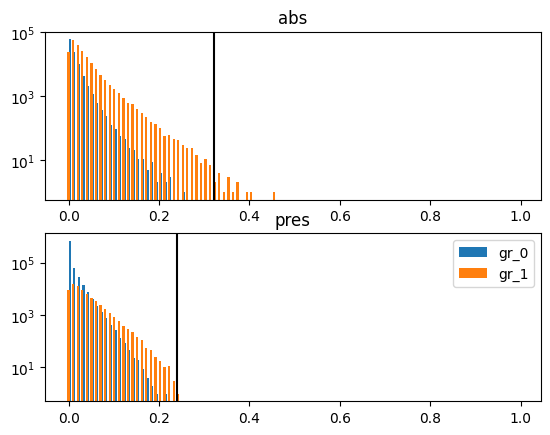

No improve counter : 1239
item counter : 1262
ratio : 0.9809976247030879
 ratio number predicted/items: 0.018210609659540775
current epoch: 9


Validation: 0it [00:00, ?it/s]

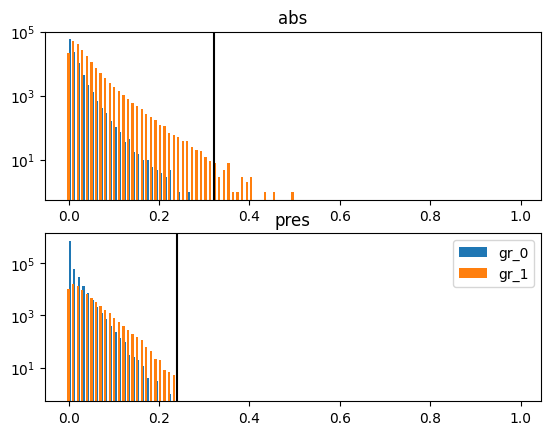

No improve counter : 1236
item counter : 1274
ratio : 0.9694117647058823
 ratio number predicted/items: 0.03215686274509804
current epoch: 10


Validation: 0it [00:00, ?it/s]

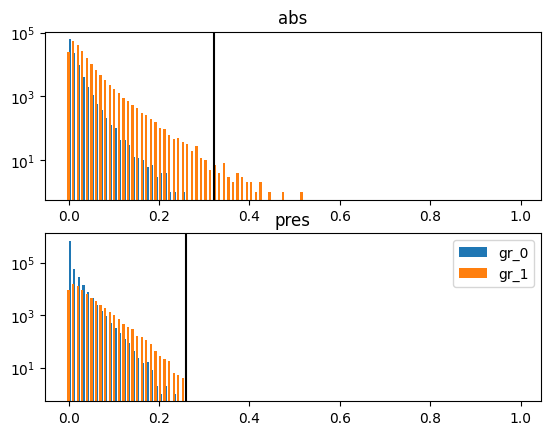

No improve counter : 1234
item counter : 1274
ratio : 0.967843137254902
 ratio number predicted/items: 0.03607843137254902
current epoch: 11


Validation: 0it [00:00, ?it/s]

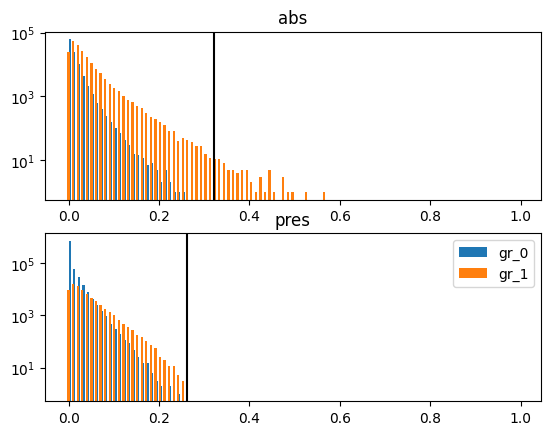

No improve counter : 1233
item counter : 1300
ratio : 0.9477325134511914
 ratio number predicted/items: 0.05995388162951576
current epoch: 12


Validation: 0it [00:00, ?it/s]

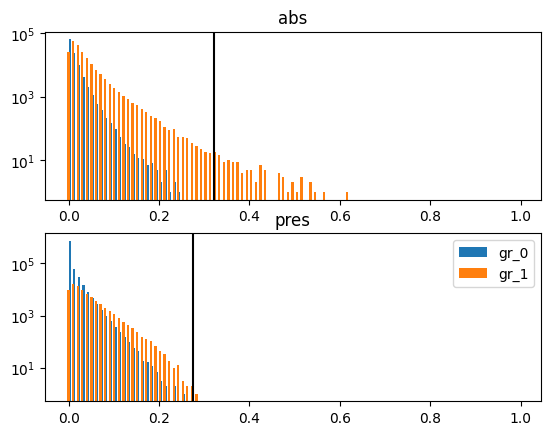

No improve counter : 1233
item counter : 1329
ratio : 0.9270676691729324
 ratio number predicted/items: 0.09323308270676692
current epoch: 13


Validation: 0it [00:00, ?it/s]

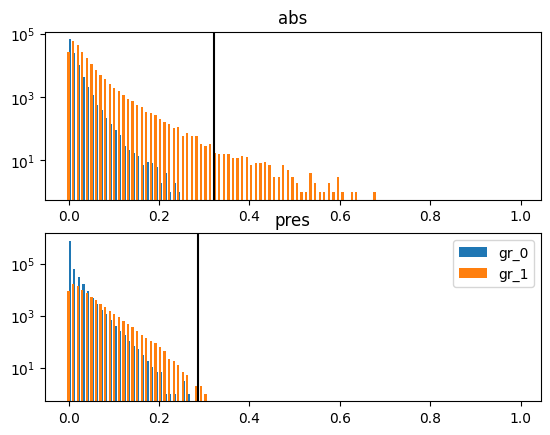

No improve counter : 1230
item counter : 1379
ratio : 0.8913043478260869
 ratio number predicted/items: 0.15
current epoch: 14


Validation: 0it [00:00, ?it/s]

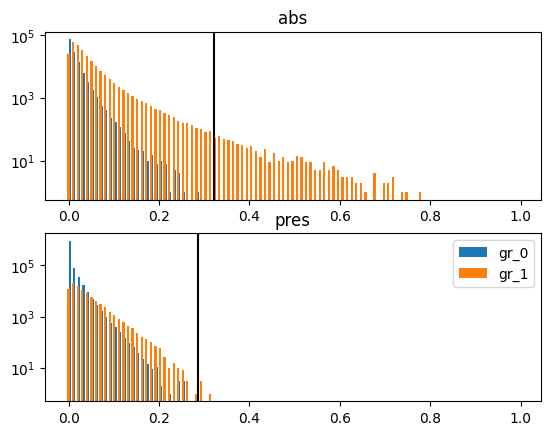

No improve counter : 1235
item counter : 1610
ratio : 0.7666045934202359
 ratio number predicted/items: 0.38423339540657975
current epoch: 15


Validation: 0it [00:00, ?it/s]

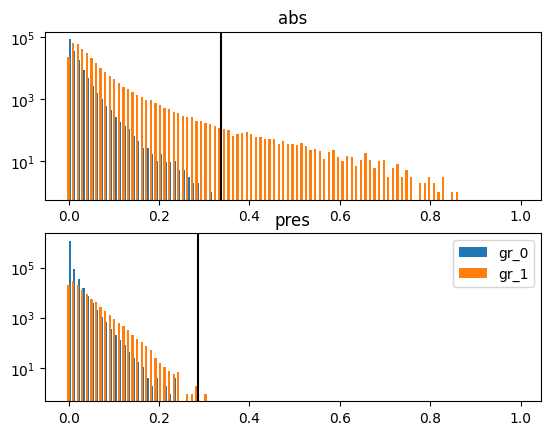

No improve counter : 1232
item counter : 1995
ratio : 0.6172344689378757
 ratio number predicted/items: 0.811122244488978
current epoch: 16


Validation: 0it [00:00, ?it/s]

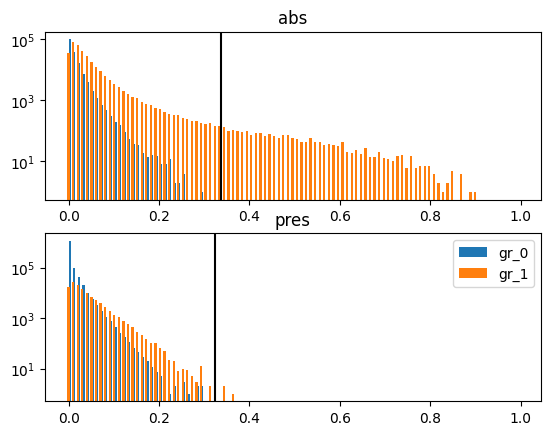

No improve counter : 1227
item counter : 2116
ratio : 0.5795937647614549
 ratio number predicted/items: 1.0354274917335853
current epoch: 17


Validation: 0it [00:00, ?it/s]

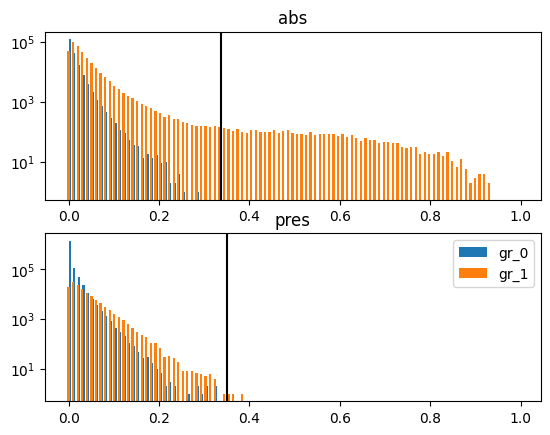

No improve counter : 1230
item counter : 2399
ratio : 0.5125
 ratio number predicted/items: 1.5420833333333333
current epoch: 18


Validation: 0it [00:00, ?it/s]

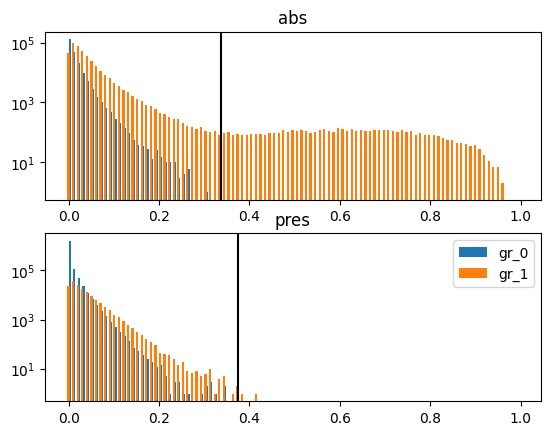

`Trainer.fit` stopped: `max_epochs=20` reached.


No improve counter : 1229
item counter : 2736
ratio : 0.44903178662769455
 ratio number predicted/items: 2.000365363536719
current epoch: 19


In [26]:
for i in range(3):
    model_checkpoint = ModelCheckpoint(monitor='ratio_number_predicted_per_items', mode='max')
    trainer = pl.Trainer(
    max_epochs=20 if i==2 else 10,
#     max_epochs=40,
    accelerator='gpu',
    devices=1,
    log_every_n_steps=1,
    # logger=pl.loggers.CSVLogger(save_dir="logs/"),
    reload_dataloaders_every_n_epochs=1,
    logger=tensorboard,
    callbacks=[model_checkpoint]
    )
    print(i)
    model = SudokuLightning(
        lr=0.01,
        prev_nets=prev_nets,
        coef_0 = 10 if i==0 else 20,
    )
    _ = trainer.fit(model,)
#     model.below_threshold_coef=0.9
#     model = model.load_from_checkpoint(model_checkpoint.best_model_path)
#     print(model_checkpoint.best_model_path)
#     trainer.validate(model=model)
#     if trainer.logged_metrics['no_improve_counter'].item()==0:
    prev_nets.append((model.net, (model.threshold_abs, model.threshold_pres)))

In [50]:
print(test_x.sum())
print(test_x[:,1].sum())
display_as_dataframe(test_x)

tensor(234.)
tensor(26.)


In [51]:
new_x = forward_from_prev_nets_all(test_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(557.)
tensor(28.)


In [52]:
prev_x = new_x.clone()
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(565.)
tensor(30.)


In [53]:
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(570.)
tensor(30.)


In [62]:
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(570.)
tensor(30.)


In [58]:
new_x.reshape((2,9,9,9))[0,6:,6:,7]

tensor([[1., 1., 0.],
        [1., 1., 1.],
        [1., 1., 0.]])

In [64]:
model.sym_preprocess(new_x).reshape(32,9,9,9)[:,:3,6:,7]

tensor([[[1.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[0.8750, 1.0000, 0.7500],
         [0.8750, 0.8750, 0.6250],
         [0.8750, 0.8750, 0.6250]],

        [[0.7500, 0.8750, 0.8750],
         [0.8750, 0.8750, 0.8750],
         [0.8750, 0.8750, 0.8750]],

        [[0.7500, 0.8750, 0.8750],
         [0.7500, 0.7500, 0.7500],
         [0.7500, 0.7500, 0.7500]],

        [[0.8333, 0.8333, 0.8333],
         [1.0000, 1.0000, 1.0000],
         [0.8333, 0.8333, 0.8333]],

        [[0.8333, 0.8333, 0.8333],
         [0.8333, 0.8333, 0.8333],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 0.8333, 0.8333],
         [1.0000, 0.8333, 0.8333],
         [1.0000, 0.8333, 0.8333]],

        [[0.6667, 0.6667, 1.0000],
         [0.6667, 0.6667, 1.0000],
         [0.6667, 0.6667, 1.0000]],

        [[0.7500, 0.7500, 0.7500],
         [0.6250, 0.8750, 0.6250],
         [0.6250, 0.6250, 0.8750]],

        [[0.7656, 0.7969, 0.6406],
  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory lightning_logs/version_81/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | net            | SmallNet          | 514   
1 | sym_preprocess | SymPreprocess     | 8.5 M 
2 | bcewll         | BCEWithLogitsLoss | 0     
3 | auroc      

0


Sanity Checking: 0it [00:00, ?it/s]

/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/tmp/ipykernel_3278/2863678930.py:187: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax1.set_yscale('log')
/tmp/ipykernel_3278/2863678930.py:193: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax2.set_yscale('log')


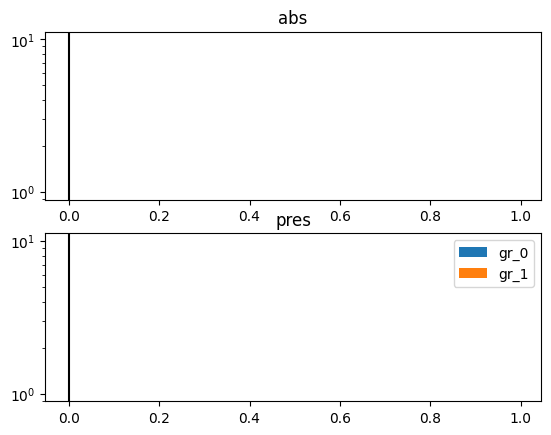

No improve counter : 0
item counter : 0
ratio : 0.0
 ratio number predicted/items: 0.0
current epoch: 0


/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

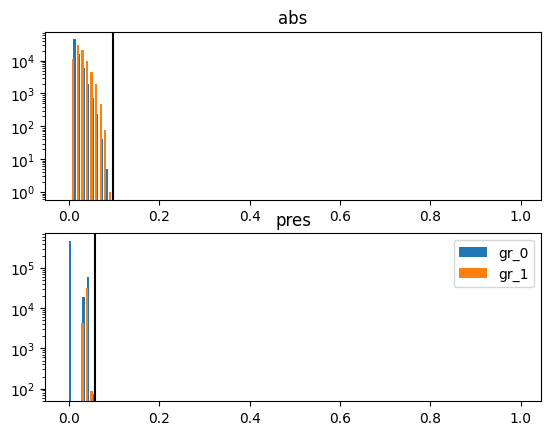

No improve counter : 848
item counter : 851
ratio : 0.9953051643192489
 ratio number predicted/items: 0.004694835680751174
current epoch: 0


Validation: 0it [00:00, ?it/s]

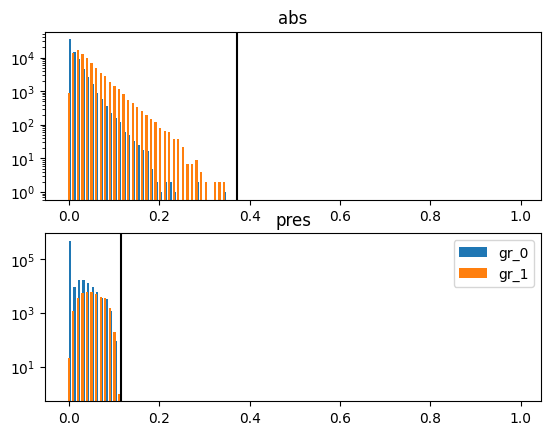

No improve counter : 849
item counter : 862
ratio : 0.9837775202780996
 ratio number predicted/items: 0.03244495944380069
current epoch: 1


Validation: 0it [00:00, ?it/s]

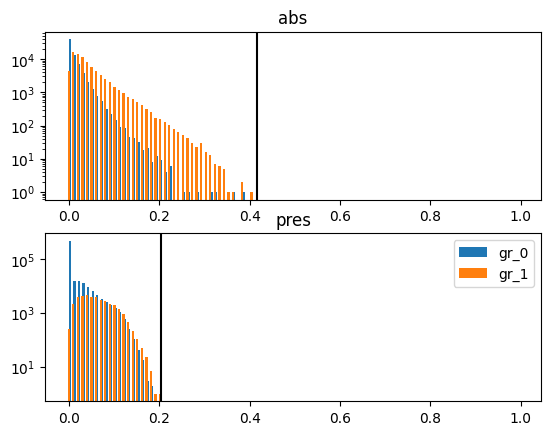

No improve counter : 847
item counter : 858
ratio : 0.9860302677532014
 ratio number predicted/items: 0.012805587892898719
current epoch: 2


Validation: 0it [00:00, ?it/s]

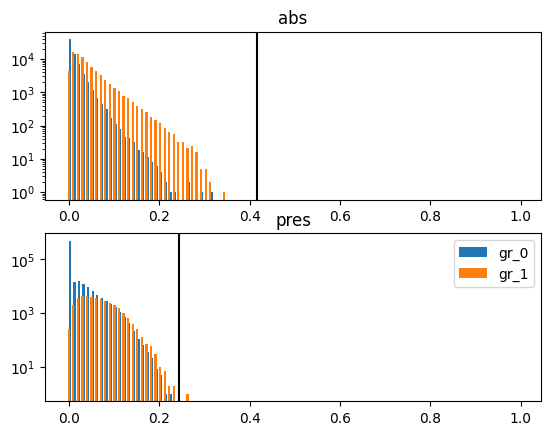

No improve counter : 845
item counter : 852
ratio : 0.9906213364595545
 ratio number predicted/items: 0.008206330597889801
current epoch: 3


Validation: 0it [00:00, ?it/s]

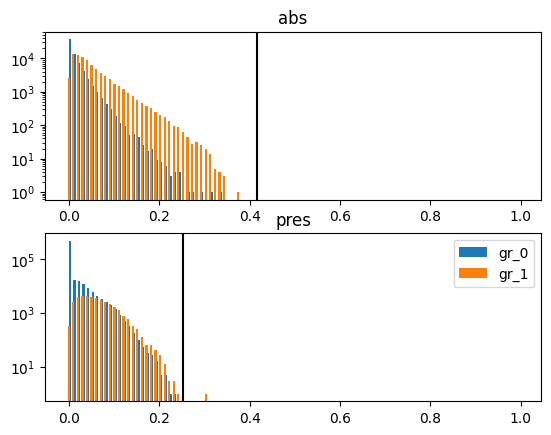

No improve counter : 847
item counter : 849
ratio : 0.9964705882352941
 ratio number predicted/items: 0.002352941176470588
current epoch: 4


Validation: 0it [00:00, ?it/s]

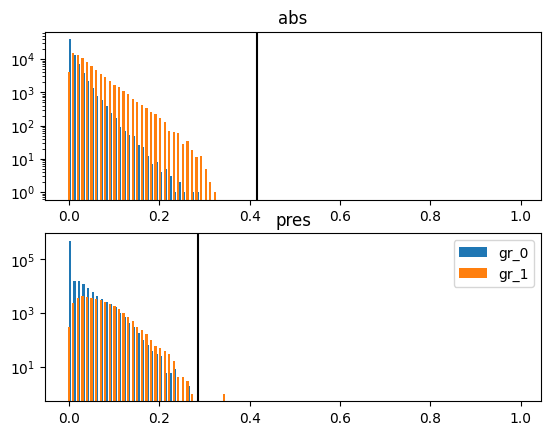

No improve counter : 848
item counter : 854
ratio : 0.991812865497076
 ratio number predicted/items: 0.007017543859649123
current epoch: 5


Validation: 0it [00:00, ?it/s]

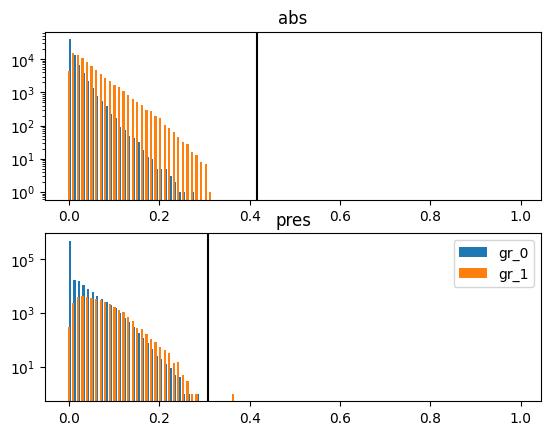

No improve counter : 848
item counter : 850
ratio : 0.9964747356051704
 ratio number predicted/items: 0.0023501762632197414
current epoch: 6


Validation: 0it [00:00, ?it/s]

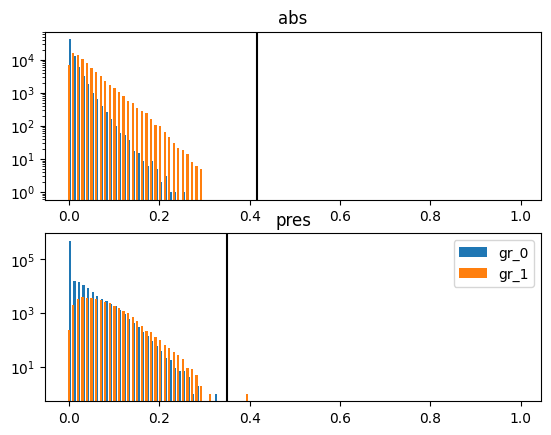

No improve counter : 849
item counter : 851
ratio : 0.9964788732394366
 ratio number predicted/items: 0.002347417840375587
current epoch: 7


Validation: 0it [00:00, ?it/s]

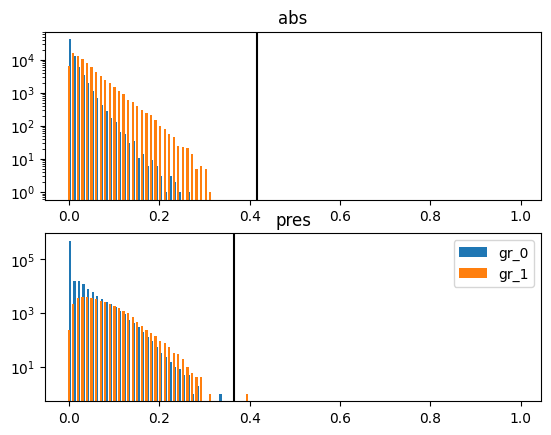

No improve counter : 848
item counter : 849
ratio : 0.9976470588235294
 ratio number predicted/items: 0.001176470588235294
current epoch: 8


Validation: 0it [00:00, ?it/s]

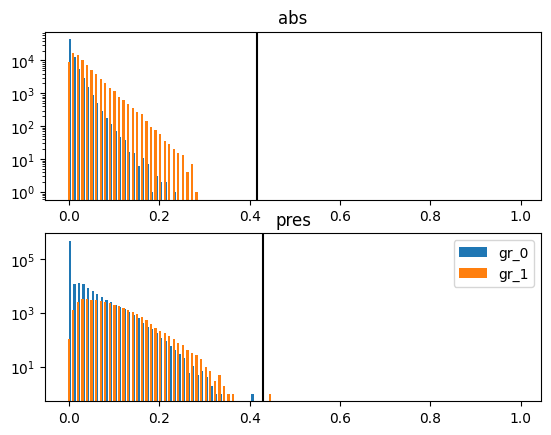

`Trainer.fit` stopped: `max_epochs=10` reached.


No improve counter : 846
item counter : 848
ratio : 0.9964664310954063
 ratio number predicted/items: 0.002355712603062426
current epoch: 9


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | net            | SmallNet          | 514   
1 | sym_preprocess | SymPreprocess     | 8.5 M 
2 | bcewll         | BCEWithLogitsLoss | 0     
3 | auroc          | BinaryAUROC       | 0     
-----------------------------------------------------
514       Trainable params
8.5 M     Non-trainable params
8.5 M     Total params
34.014    Total estimated model params size (MB)


1


Sanity Checking: 0it [00:00, ?it/s]

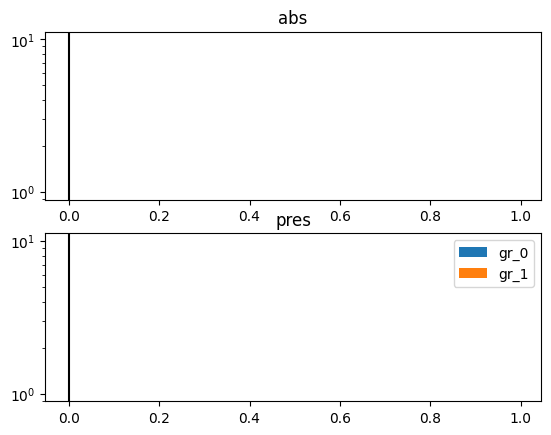

No improve counter : 0
item counter : 0
ratio : 0.0
 ratio number predicted/items: 0.0
current epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

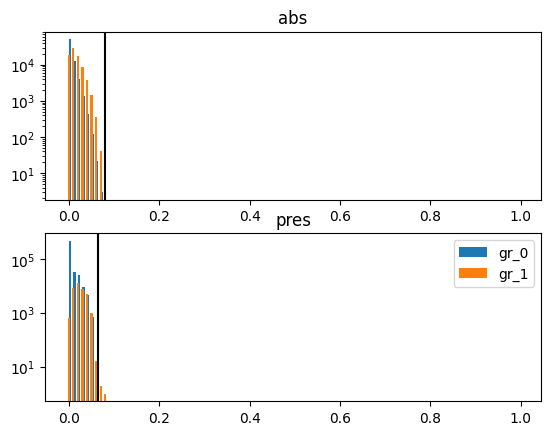

No improve counter : 842
item counter : 861
ratio : 0.9767981438515081
 ratio number predicted/items: 0.031322505800464036
current epoch: 0


Validation: 0it [00:00, ?it/s]

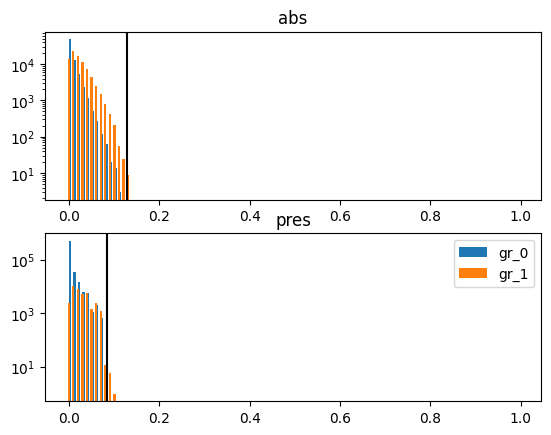

No improve counter : 839
item counter : 874
ratio : 0.9588571428571429
 ratio number predicted/items: 0.07771428571428571
current epoch: 1


Validation: 0it [00:00, ?it/s]

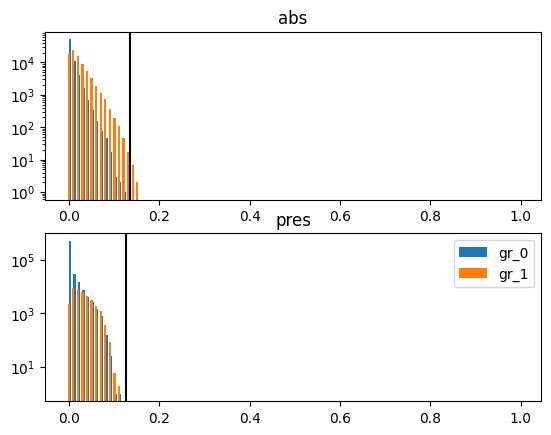

No improve counter : 846
item counter : 865
ratio : 0.976905311778291
 ratio number predicted/items: 0.03348729792147806
current epoch: 2


Validation: 0it [00:00, ?it/s]

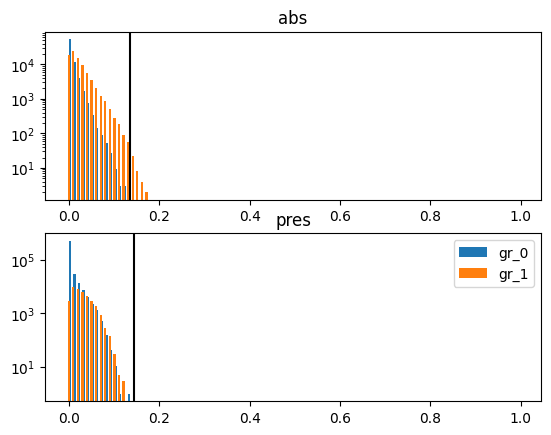

No improve counter : 846
item counter : 887
ratio : 0.9527027027027027
 ratio number predicted/items: 0.06644144144144144
current epoch: 3


Validation: 0it [00:00, ?it/s]

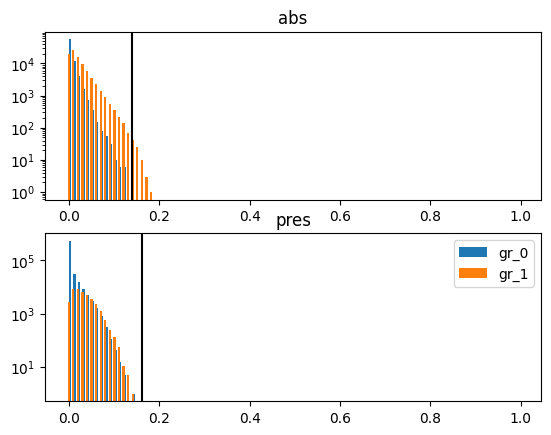

No improve counter : 845
item counter : 927
ratio : 0.9105603448275862
 ratio number predicted/items: 0.11422413793103449
current epoch: 4


Validation: 0it [00:00, ?it/s]

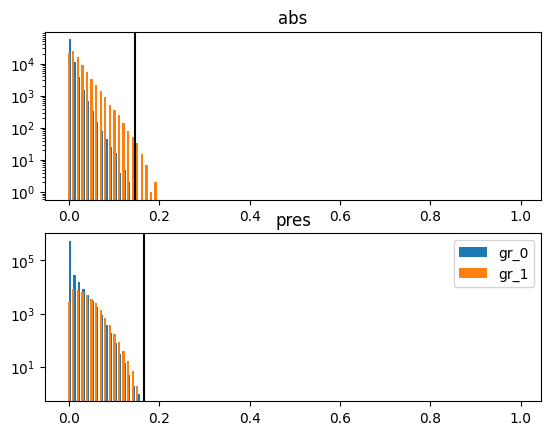

No improve counter : 845
item counter : 937
ratio : 0.9008528784648188
 ratio number predicted/items: 0.1162046908315565
current epoch: 5


Validation: 0it [00:00, ?it/s]

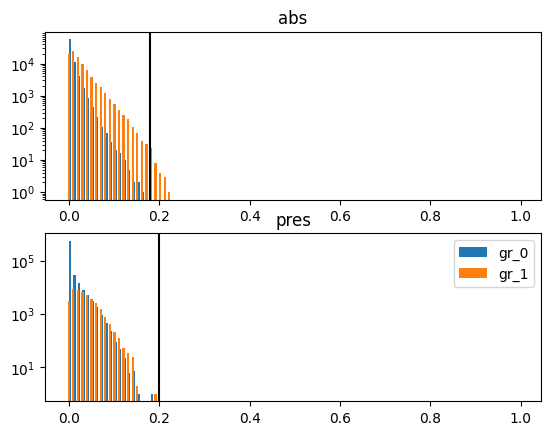

No improve counter : 845
item counter : 951
ratio : 0.8876050420168067
 ratio number predicted/items: 0.13130252100840337
current epoch: 6


Validation: 0it [00:00, ?it/s]

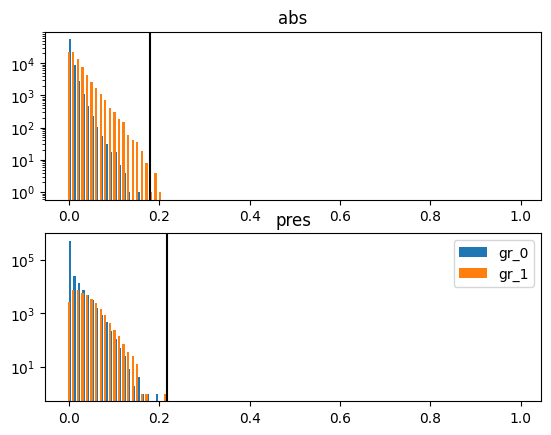

No improve counter : 845
item counter : 853
ratio : 0.9894613583138173
 ratio number predicted/items: 0.00936768149882904
current epoch: 7


Validation: 0it [00:00, ?it/s]

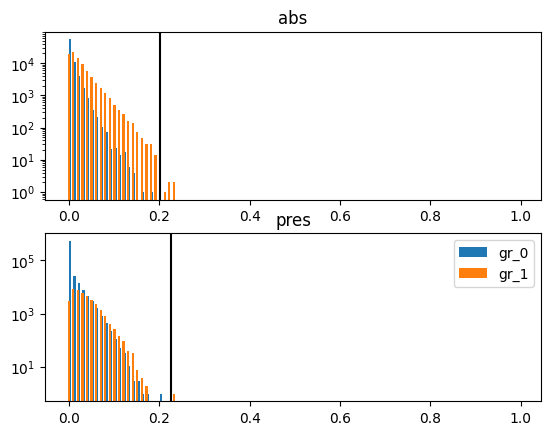

No improve counter : 845
item counter : 897
ratio : 0.9409799554565702
 ratio number predicted/items: 0.0645879732739421
current epoch: 8


Validation: 0it [00:00, ?it/s]

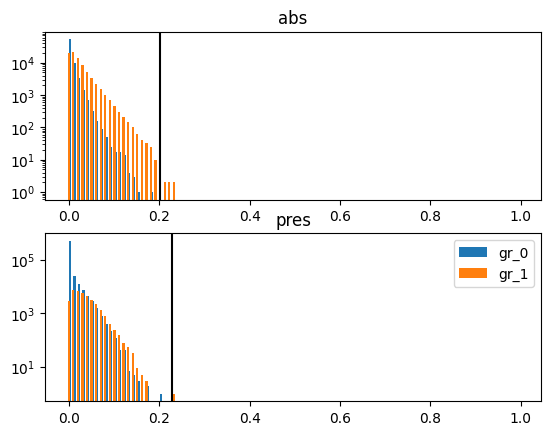

`Trainer.fit` stopped: `max_epochs=10` reached.


No improve counter : 845
item counter : 854
ratio : 0.9883040935672515
 ratio number predicted/items: 0.011695906432748537
current epoch: 9


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | net            | SmallNet          | 514   
1 | sym_preprocess | SymPreprocess     | 8.5 M 
2 | bcewll         | BCEWithLogitsLoss | 0     
3 | auroc          | BinaryAUROC       | 0     
-----------------------------------------------------
514       Trainable params
8.5 M     Non-trainable params
8.5 M     Total params
34.014    Total estimated model params size (MB)


2


Sanity Checking: 0it [00:00, ?it/s]

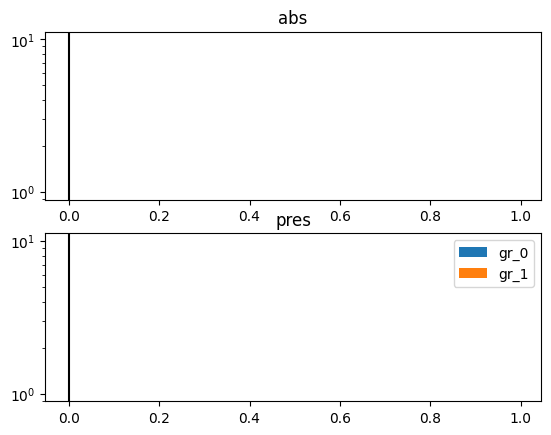

No improve counter : 0
item counter : 0
ratio : 0.0
 ratio number predicted/items: 0.0
current epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

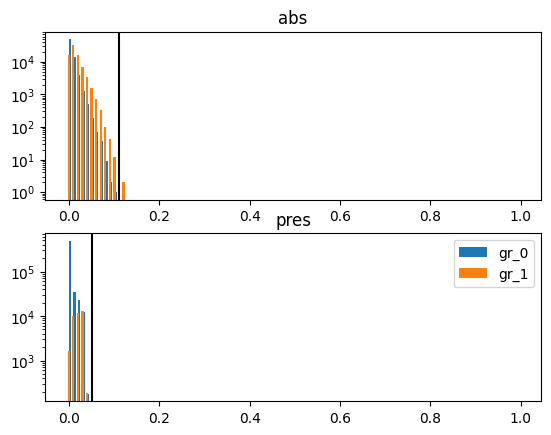

No improve counter : 847
item counter : 859
ratio : 0.9848837209302326
 ratio number predicted/items: 0.030232558139534883
current epoch: 0


Validation: 0it [00:00, ?it/s]

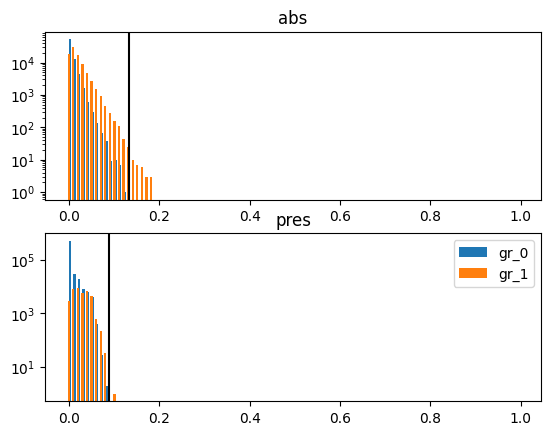

No improve counter : 846
item counter : 896
ratio : 0.9431438127090301
 ratio number predicted/items: 0.08361204013377926
current epoch: 1


Validation: 0it [00:00, ?it/s]

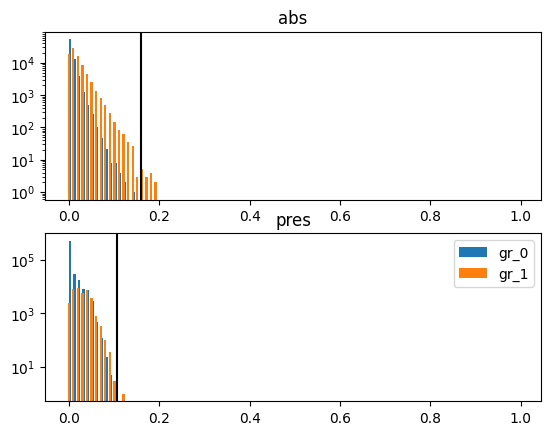

No improve counter : 847
item counter : 894
ratio : 0.9463687150837988
 ratio number predicted/items: 0.06815642458100558
current epoch: 2


Validation: 0it [00:00, ?it/s]

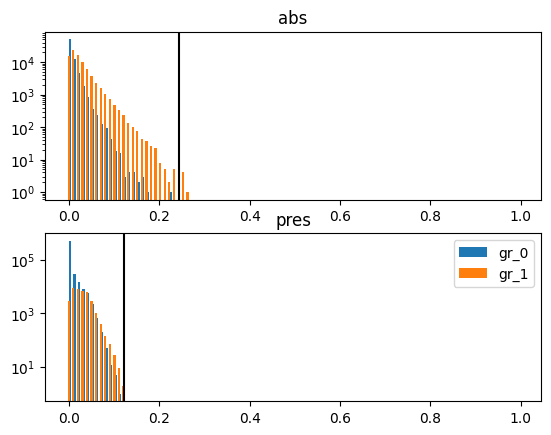

No improve counter : 845
item counter : 884
ratio : 0.9548022598870056
 ratio number predicted/items: 0.05423728813559322
current epoch: 3


Validation: 0it [00:00, ?it/s]

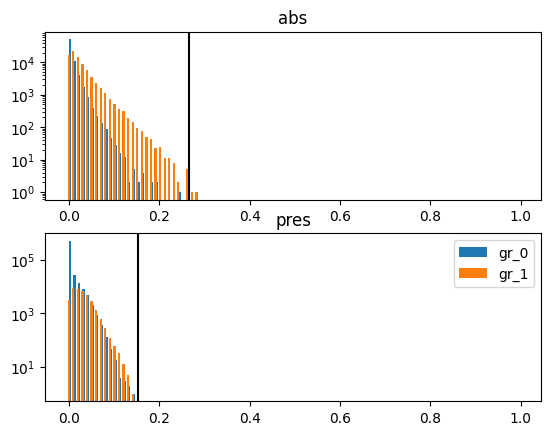

No improve counter : 846
item counter : 859
ratio : 0.9837209302325581
 ratio number predicted/items: 0.01627906976744186
current epoch: 4


Validation: 0it [00:00, ?it/s]

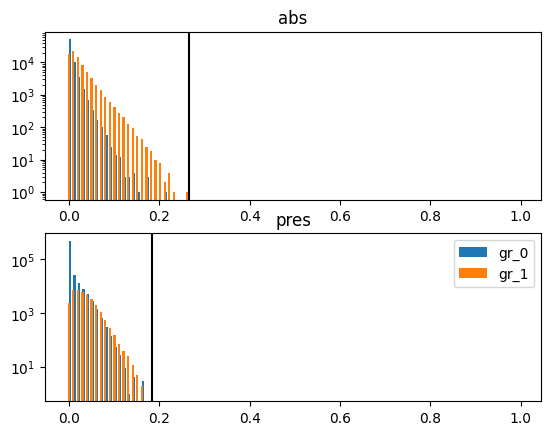

No improve counter : 845
item counter : 848
ratio : 0.9952885747938751
 ratio number predicted/items: 0.0035335689045936395
current epoch: 5


Validation: 0it [00:00, ?it/s]

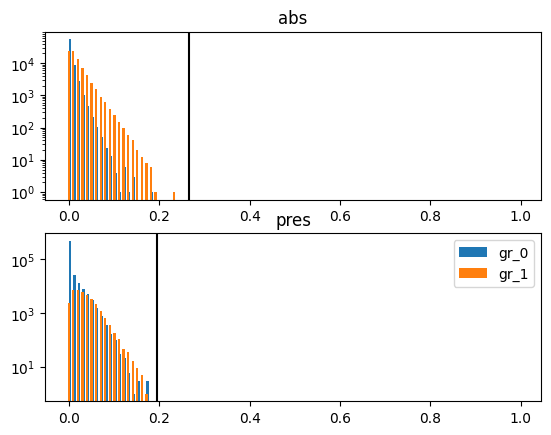

No improve counter : 846
item counter : 846
ratio : 0.9988193624557261
 ratio number predicted/items: 0.0
current epoch: 6


In [39]:
for i in range(3):
    model_checkpoint = ModelCheckpoint(monitor='ratio_number_predicted_per_items', mode='max')
    trainer = pl.Trainer(
    max_epochs=20 if i==2 else 10,
#     max_epochs=40,
    accelerator='gpu',
    devices=1,
    log_every_n_steps=1,
    # logger=pl.loggers.CSVLogger(save_dir="logs/"),
    reload_dataloaders_every_n_epochs=1,
    logger=tensorboard,
    callbacks=[model_checkpoint]
    )
    print(i)
    model = SudokuLightning(
        lr=0.01,
        prev_nets=prev_nets,
        coef_0 = 10 if i==0 else 20,
    )
    _ = trainer.fit(model,)
#     model.below_threshold_coef=0.9
#     model = model.load_from_checkpoint(model_checkpoint.best_model_path)
#     print(model_checkpoint.best_model_path)
#     trainer.validate(model=model)
#     if trainer.logged_metrics['no_improve_counter'].item()==0:
    prev_nets.append((model.net, (model.threshold_abs, model.threshold_pres)))

In [41]:
import joblib
dump_list = []
for i, (prev_net, (th_abs, th_pres) )in enumerate(prev_nets):
    net_name = f"net_{i}"
    torch.save(prev_net.state_dict(), net_name)
    dump_list.append((net_name,(th_abs, th_pres)))
joblib.dump(dump_list, "thresholds.dump")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | net            | SmallNet          | 514   
1 | sym_preprocess | SymPreprocess     | 8.5 M 
2 | bcewll         | BCEWithLogitsLoss | 0     
3 | auroc          | BinaryAUROC       | 0     
-----------------------------------------------------
514       Trainable params
8.5 M     Non-trainable params
8.5 M     Total params
34.014    Total estimated model params size (MB)


0


Sanity Checking: 0it [00:00, ?it/s]

/tmp/ipykernel_3278/2863678930.py:187: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax1.set_yscale('log')
/tmp/ipykernel_3278/2863678930.py:193: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax2.set_yscale('log')


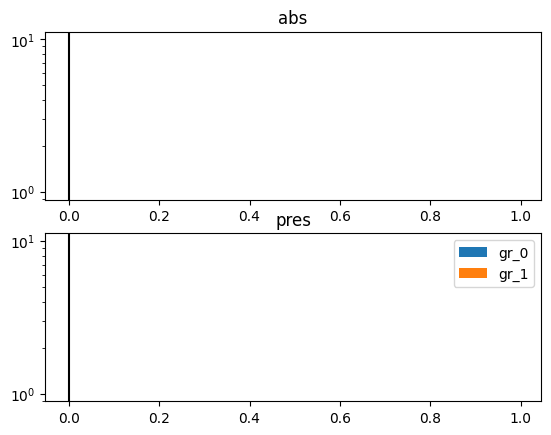

No improve counter : 0
item counter : 0
ratio : 0.0
 ratio number predicted/items: 0.0
current epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

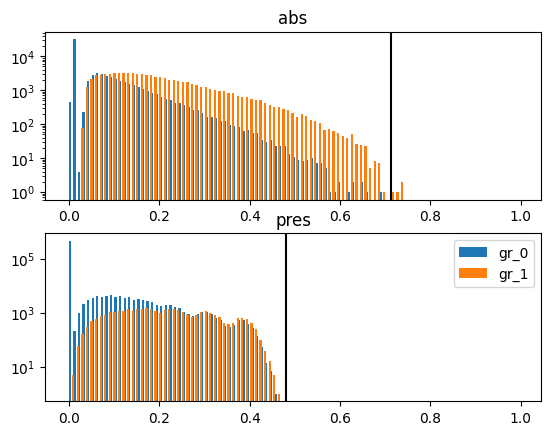

No improve counter : 812
item counter : 830
ratio : 0.9771359807460891
 ratio number predicted/items: 0.044524669073405534
current epoch: 0


Validation: 0it [00:00, ?it/s]

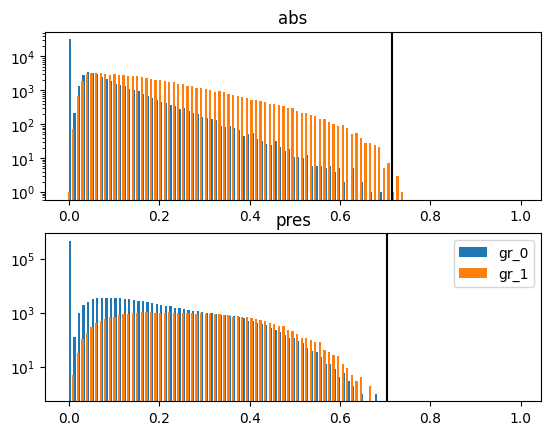

No improve counter : 812
item counter : 827
ratio : 0.9806763285024155
 ratio number predicted/items: 0.018115942028985508
current epoch: 1


Validation: 0it [00:00, ?it/s]

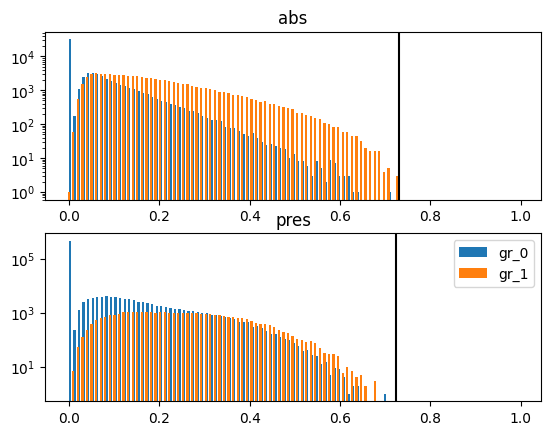

No improve counter : 814
item counter : 818
ratio : 0.9938949938949939
 ratio number predicted/items: 0.004884004884004884
current epoch: 2


Validation: 0it [00:00, ?it/s]

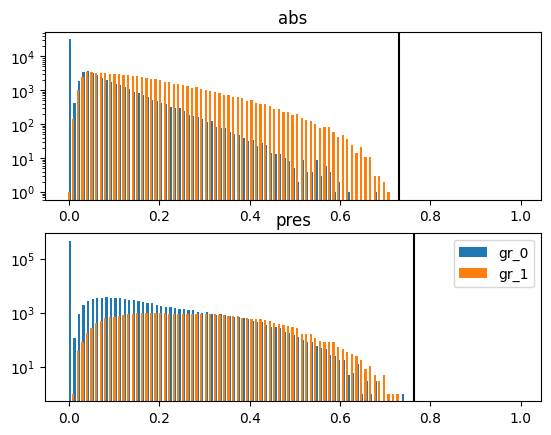

No improve counter : 813
item counter : 815
ratio : 0.9963235294117647
 ratio number predicted/items: 0.0024509803921568627
current epoch: 3


Validation: 0it [00:00, ?it/s]

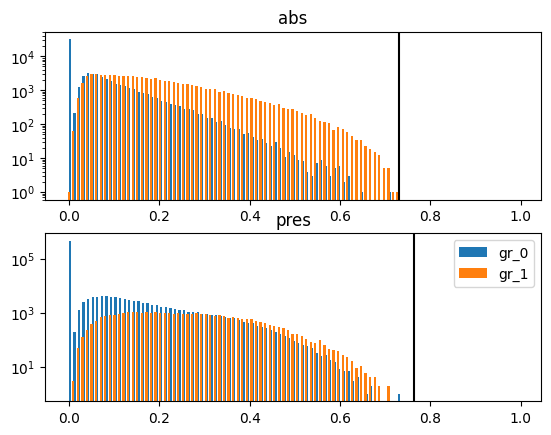

No improve counter : 812
item counter : 813
ratio : 0.9975429975429976
 ratio number predicted/items: 0.0012285012285012285
current epoch: 4


Validation: 0it [00:00, ?it/s]

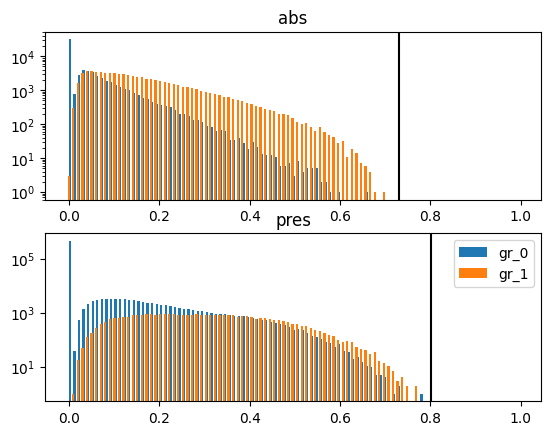

No improve counter : 811
item counter : 813
ratio : 0.9963144963144963
 ratio number predicted/items: 0.002457002457002457
current epoch: 5


Validation: 0it [00:00, ?it/s]

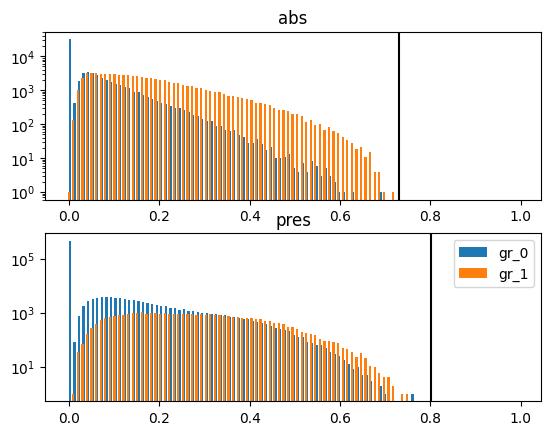

No improve counter : 813
item counter : 813
ratio : 0.9987714987714987
 ratio number predicted/items: 0.0
current epoch: 6


Validation: 0it [00:00, ?it/s]

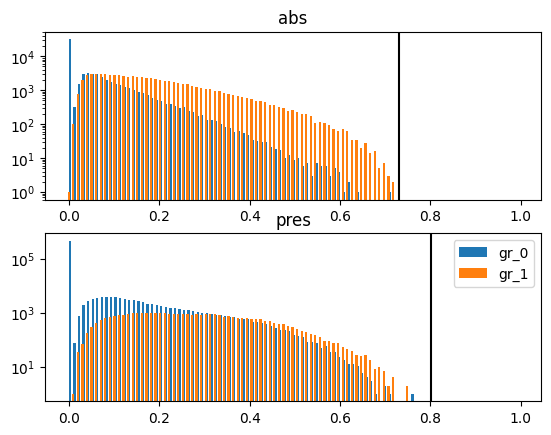

No improve counter : 813
item counter : 813
ratio : 0.9987714987714987
 ratio number predicted/items: 0.0
current epoch: 7


Validation: 0it [00:00, ?it/s]

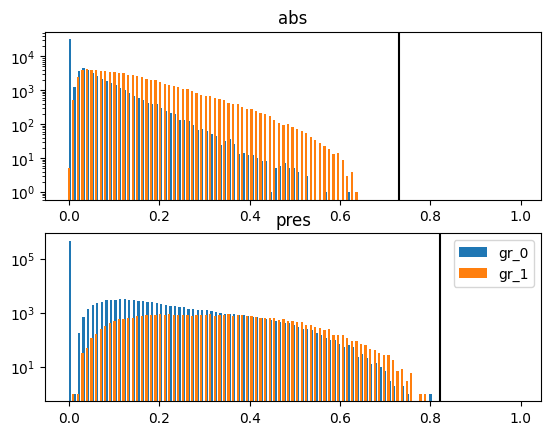

No improve counter : 814
item counter : 814
ratio : 0.9987730061349693
 ratio number predicted/items: 0.0
current epoch: 8


Validation: 0it [00:00, ?it/s]

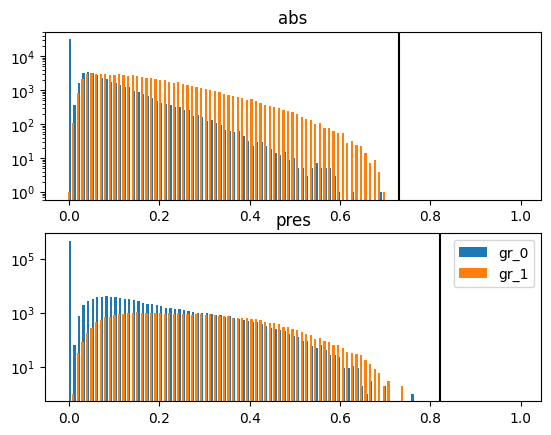

`Trainer.fit` stopped: `max_epochs=10` reached.


No improve counter : 812
item counter : 812
ratio : 0.998769987699877
 ratio number predicted/items: 0.0
current epoch: 9


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | net            | SmallNet          | 514   
1 | sym_preprocess | SymPreprocess     | 8.5 M 
2 | bcewll         | BCEWithLogitsLoss | 0     
3 | auroc          | BinaryAUROC       | 0     
-----------------------------------------------------
514       Trainable params
8.5 M     Non-trainable params
8.5 M     Total params
34.014    Total estimated model params size (MB)


1


Sanity Checking: 0it [00:00, ?it/s]

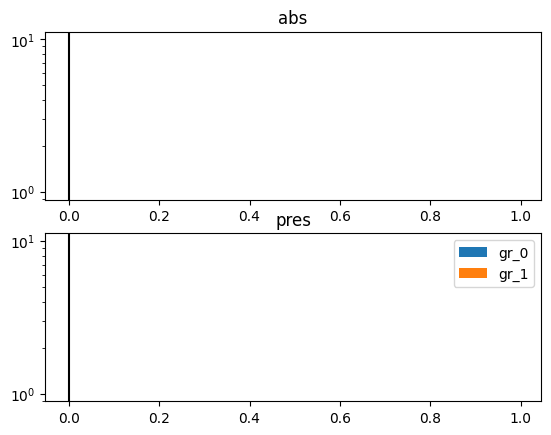

No improve counter : 0
item counter : 0
ratio : 0.0
 ratio number predicted/items: 0.0
current epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

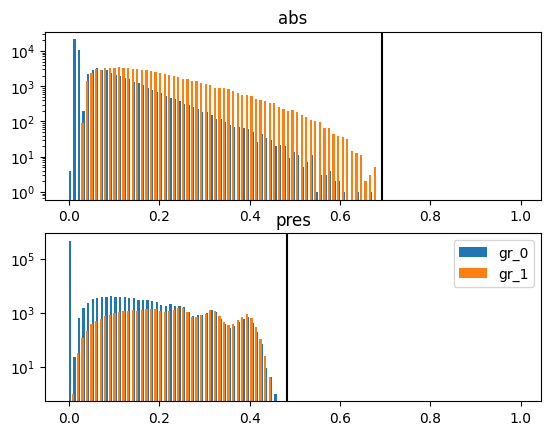

No improve counter : 814
item counter : 829
ratio : 0.980722891566265
 ratio number predicted/items: 0.027710843373493974
current epoch: 0


Validation: 0it [00:00, ?it/s]

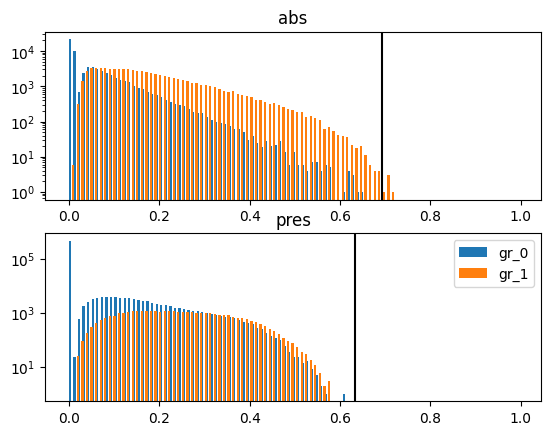

No improve counter : 811
item counter : 822
ratio : 0.9854191980558931
 ratio number predicted/items: 0.013365735115431349
current epoch: 1


Validation: 0it [00:00, ?it/s]

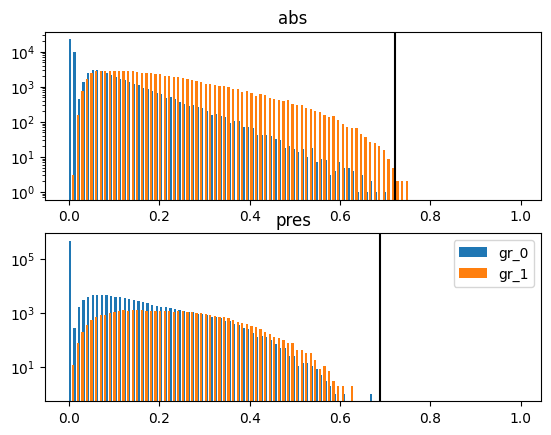

No improve counter : 814
item counter : 841
ratio : 0.9667458432304038
 ratio number predicted/items: 0.032066508313539195
current epoch: 2


Validation: 0it [00:00, ?it/s]

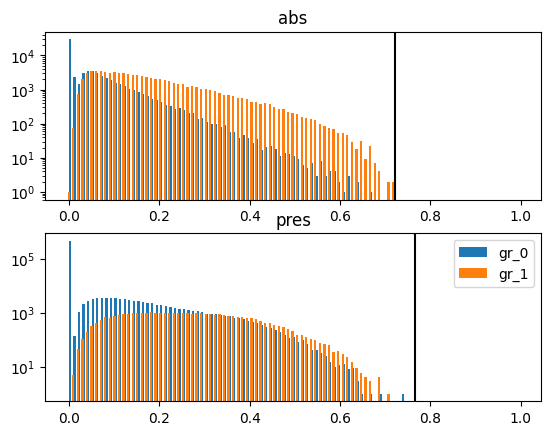

No improve counter : 813
item counter : 817
ratio : 0.9938875305623472
 ratio number predicted/items: 0.004889975550122249
current epoch: 3


Validation: 0it [00:00, ?it/s]

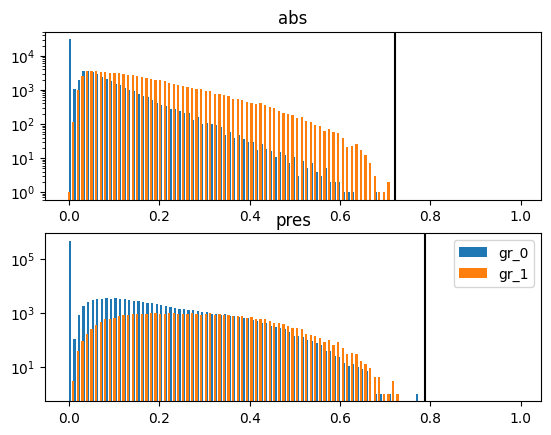

No improve counter : 813
item counter : 813
ratio : 0.9987714987714987
 ratio number predicted/items: 0.0
current epoch: 4


Validation: 0it [00:00, ?it/s]

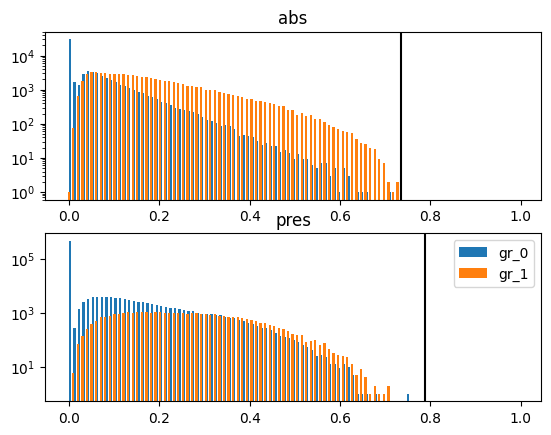

No improve counter : 812
item counter : 815
ratio : 0.9950980392156863
 ratio number predicted/items: 0.003676470588235294
current epoch: 5


Validation: 0it [00:00, ?it/s]

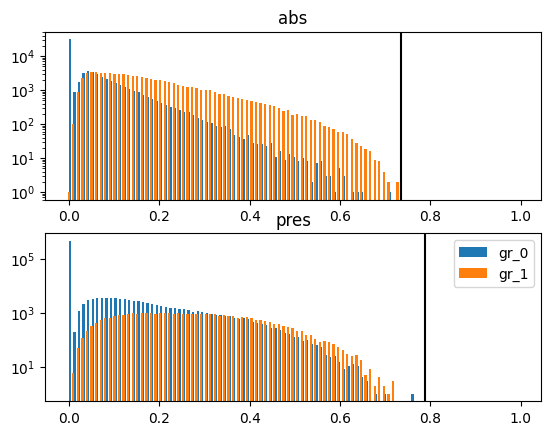

No improve counter : 813
item counter : 813
ratio : 0.9987714987714987
 ratio number predicted/items: 0.0
current epoch: 6


Validation: 0it [00:00, ?it/s]

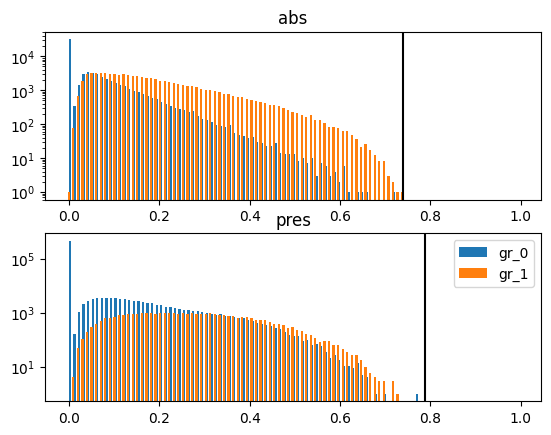

No improve counter : 814
item counter : 816
ratio : 0.996328029375765
 ratio number predicted/items: 0.0024479804161566705
current epoch: 7


Validation: 0it [00:00, ?it/s]

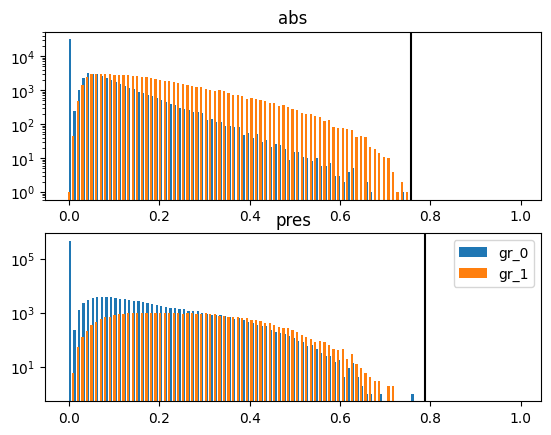

No improve counter : 813
item counter : 815
ratio : 0.9963235294117647
 ratio number predicted/items: 0.0024509803921568627
current epoch: 8


Validation: 0it [00:00, ?it/s]

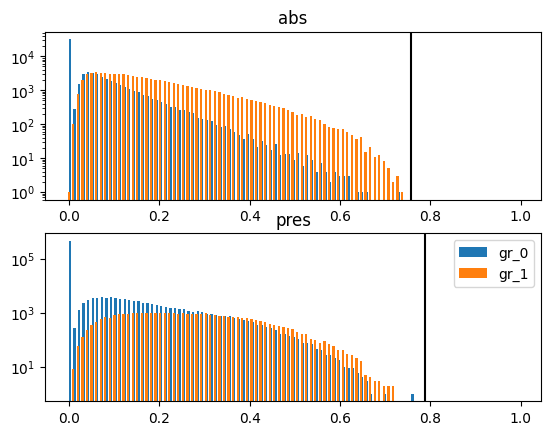

`Trainer.fit` stopped: `max_epochs=10` reached.


No improve counter : 814
item counter : 814
ratio : 0.9987730061349693
 ratio number predicted/items: 0.0
current epoch: 9


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | net            | SmallNet          | 514   
1 | sym_preprocess | SymPreprocess     | 8.5 M 
2 | bcewll         | BCEWithLogitsLoss | 0     
3 | auroc          | BinaryAUROC       | 0     
-----------------------------------------------------
514       Trainable params
8.5 M     Non-trainable params
8.5 M     Total params
34.014    Total estimated model params size (MB)


2


Sanity Checking: 0it [00:00, ?it/s]

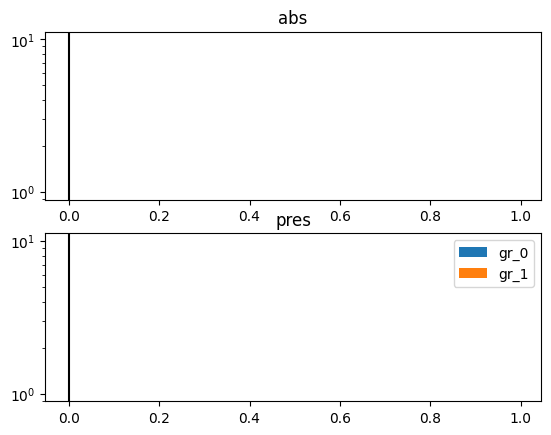

No improve counter : 0
item counter : 0
ratio : 0.0
 ratio number predicted/items: 0.0
current epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

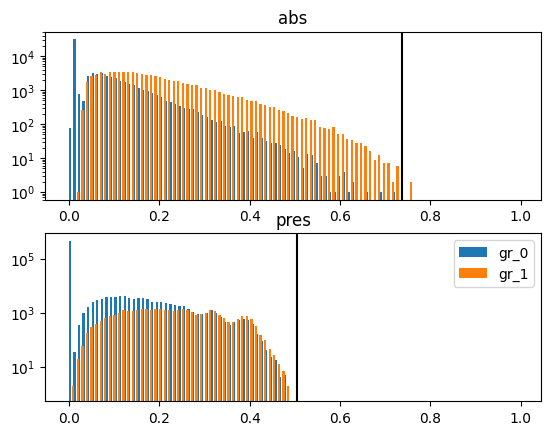

No improve counter : 812
item counter : 840
ratio : 0.9655172413793104
 ratio number predicted/items: 0.052318668252080855
current epoch: 0


Validation: 0it [00:00, ?it/s]

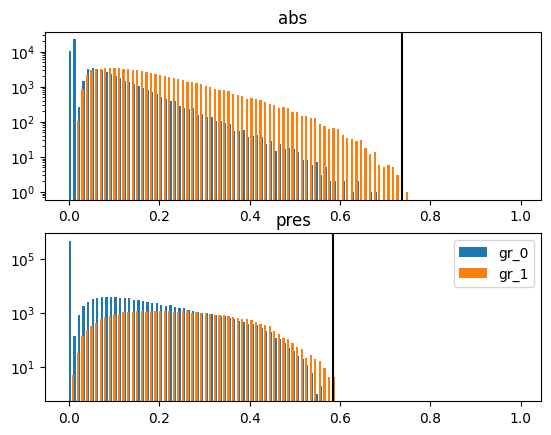

No improve counter : 812
item counter : 837
ratio : 0.9689737470167065
 ratio number predicted/items: 0.031026252983293555
current epoch: 1


Validation: 0it [00:00, ?it/s]

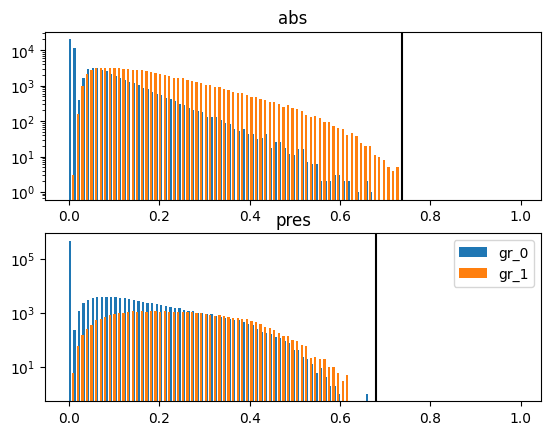

No improve counter : 813
item counter : 817
ratio : 0.9938875305623472
 ratio number predicted/items: 0.004889975550122249
current epoch: 2


Validation: 0it [00:00, ?it/s]

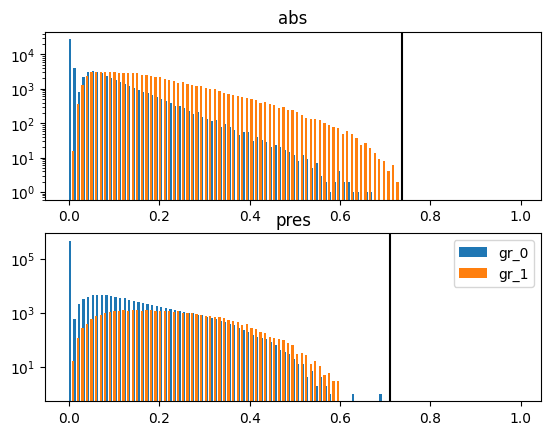

No improve counter : 812
item counter : 813
ratio : 0.9975429975429976
 ratio number predicted/items: 0.0012285012285012285
current epoch: 3


Validation: 0it [00:00, ?it/s]

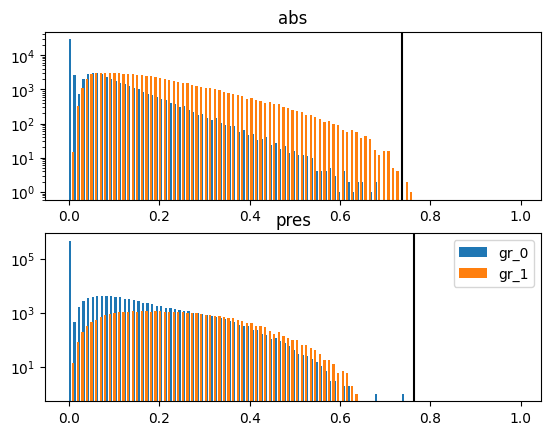

No improve counter : 811
item counter : 814
ratio : 0.9950920245398773
 ratio number predicted/items: 0.0049079754601227
current epoch: 4


Validation: 0it [00:00, ?it/s]

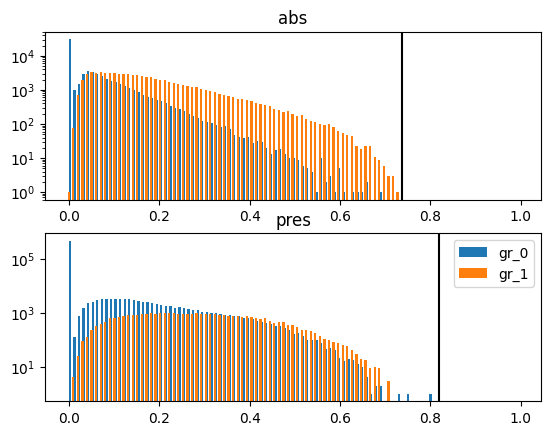

No improve counter : 813
item counter : 814
ratio : 0.9975460122699387
 ratio number predicted/items: 0.001226993865030675
current epoch: 5


Validation: 0it [00:00, ?it/s]

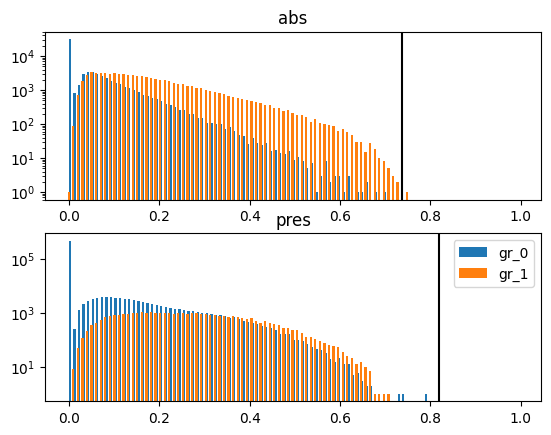

No improve counter : 812
item counter : 813
ratio : 0.9975429975429976
 ratio number predicted/items: 0.0012285012285012285
current epoch: 6


Validation: 0it [00:00, ?it/s]

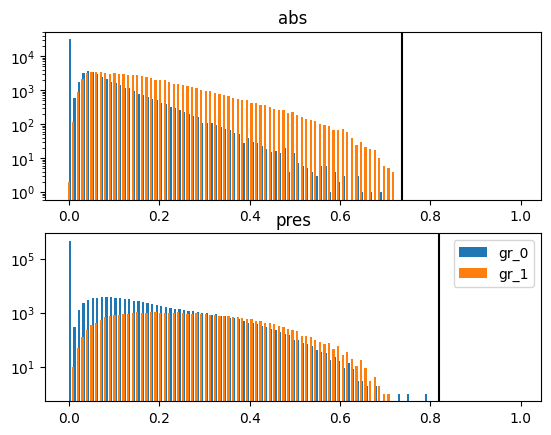

No improve counter : 812
item counter : 813
ratio : 0.9975429975429976
 ratio number predicted/items: 0.0012285012285012285
current epoch: 7


Validation: 0it [00:00, ?it/s]

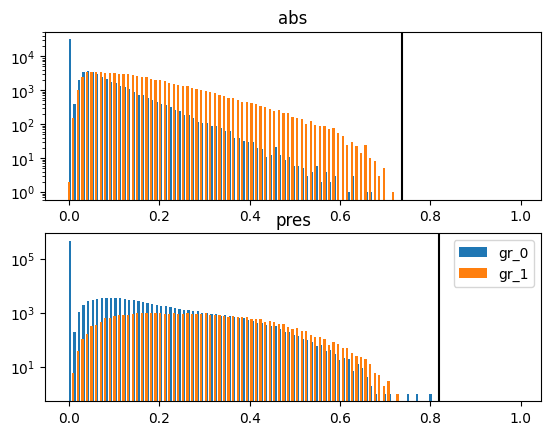

No improve counter : 814
item counter : 814
ratio : 0.9987730061349693
 ratio number predicted/items: 0.0
current epoch: 8


Validation: 0it [00:00, ?it/s]

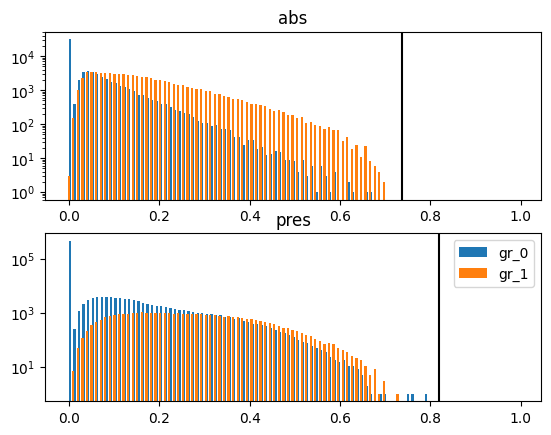

`Trainer.fit` stopped: `max_epochs=10` reached.


No improve counter : 810
item counter : 810
ratio : 0.998766954377312
 ratio number predicted/items: 0.0
current epoch: 9


In [49]:
for i in range(3):
    model_checkpoint = ModelCheckpoint(monitor='ratio_number_predicted_per_items', mode='max')
    trainer = pl.Trainer(
    max_epochs=10,
#     max_epochs=40,
    accelerator='gpu',
    devices=1,
    log_every_n_steps=1,
    # logger=pl.loggers.CSVLogger(save_dir="logs/"),
    reload_dataloaders_every_n_epochs=1,
    logger=tensorboard,
    callbacks=[model_checkpoint]
    )
    print(i)
    model = SudokuLightning(
        lr=0.01,
        prev_nets=prev_nets,
        coef_0 = 2,
    )
    _ = trainer.fit(model,)
#     model.below_threshold_coef=0.9
#     model = model.load_from_checkpoint(model_checkpoint.best_model_path)
#     print(model_checkpoint.best_model_path)
#     trainer.validate(model=model)
#     if trainer.logged_metrics['no_improve_counter'].item()==0:
    prev_nets.append((model.net, (model.threshold_abs, model.threshold_pres)))

In [ ]:
from sudoku.loader import get_datasets
from tqdm.notebook import tqdm

In [ ]:
train, test = get_datasets(train_size=5000, test_size=5000)

In [ ]:
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, full_loop=False)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
new_prev_nets = copy(prev_nets)
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=new_prev_nets, fix=True)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
new_prev_nets = copy(prev_nets)
for x,y in tqdm(test):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=new_prev_nets, fix=True)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
# new_prev_nets = copy(prev_nets)
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=new_prev_nets, fix=False)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
# new_prev_nets = copy(prev_nets)
for x,y in tqdm(test):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=new_prev_nets, fix=False)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
prev_nets

In [ ]:
new_prev_nets

In [ ]:
final_nets = []
marging = 0.3
for net_ths_1, net_ths_2 in zip(prev_nets, new_prev_nets):
    th_abs = net_ths_2[1][0] 
    if net_ths_1[1][0] != net_ths_2[1][0]:
        th_abs = net_ths_2[1][0] + marging
    else:
        th_abs = net_ths_2[1][0]
        
    if net_ths_1[1][1] != net_ths_2[1][1]:
        th_pres = net_ths_2[1][1] + marging
    else:
        th_pres = net_ths_2[1][1]
    final_nets.append((net_ths_2[0], (th_abs, th_pres)))

In [ ]:
# new_prev_nets = copy(prev_nets)
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=final_nets, fix=False, full_loop=False)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
new_prev_nets = copy(final_nets)
for x,y in tqdm(test):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=new_prev_nets, fix=True)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
# new_prev_nets = copy(prev_nets)
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=new_prev_nets, fix=True)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
# new_prev_nets = copy(prev_nets)
for x,y in tqdm(test):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=new_prev_nets, fix=True, full_loop=False)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
# new_prev_nets = copy(prev_nets)
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=final_nets, fix=False, full_loop=False)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
# new_prev_nets = copy(prev_nets)
for x,y in tqdm(test):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=new_prev_nets, fix=False, full_loop=False)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
import joblib
dump_list = []
for i, (prev_net, (th_abs, th_pres) )in enumerate(final_nets):
    net_name = f"f1_net_{i}"
    torch.save(prev_net.state_dict(), net_name)
    dump_list.append((net_name,(th_abs, th_pres)))
joblib.dump(dump_list, "final_1_nets_thresholds.dump")